<a href="https://colab.research.google.com/github/ATLAS097/Deep-Learning-CA-2/blob/Swam/GAN_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network - New Image Generation
### Group Member: Swam Htet Aung, Kaung Myat San
### Class: DAAA/FT/2B/22
---



### Setup
---

### Importing Modules

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Utilities
import os
import warnings
from PIL import Image
from scipy import linalg
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available (TensorFlow): {tf.config.list_physical_devices('GPU')}")
print(f"GPU available (PyTorch): {torch.cuda.is_available()}")

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=6144)]) # 6GB limit per GPU

print(tf.config.list_physical_devices())


Libraries imported successfully!
TensorFlow version: 2.19.0
PyTorch version: 2.6.0+cu124
GPU available (TensorFlow): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU available (PyTorch): True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Background Research & Data Analysis
---
### Data Loading and Exploration
---
Let's load the EMNIST letters dataset and analyze its structure.

In [2]:
# Load the EMNIST letters dataset
data = pd.read_csv('https://media.githubusercontent.com/media/ATLAS097/assets/refs/heads/main/SP_DELE_CA2_YEAR_2/emnist-letters-train.csv', header=None)

# Rename columns for clarity (first column is label, rest are pixel values)
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
data.columns = column_names

print(f"Dataset shape: {data.shape}")
print(f"Dataset columns: {data.columns.tolist()}")
print(f"First few column names: {data.columns[:10].tolist()}")

# Check for missing values
print(f"\nMissing values: {data.isnull().sum().sum()}")

# Display first few rows
print("\nFirst 5 rows:")
print(data.head())

# Check unique labels
if '0' in data.columns:
    unique_labels = sorted(data['0'].unique())
    print(f"\nUnique labels: {unique_labels}")
    print(f"Number of classes: {len(unique_labels)}")

    # Label distribution
    label_counts = data['0'].value_counts().sort_index()
    print(f"\nLabel distribution:")
    for label, count in label_counts.items():
        print(f"Class {label}: {count} samples")

    # Plot label distribution
    plt.figure(figsize=(12, 6))
    plt.bar(label_counts.index, label_counts.values)
    plt.title('Distribution of Letter Classes in EMNIST Dataset')
    plt.xlabel('Letter Class')
    plt.ylabel('Number of Samples')
    plt.xticks(label_counts.index)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Label column not found. Checking dataset structure...")
    print(data.describe())

Dataset shape: (64829, 785)
Dataset columns: ['label', 'pixel_0', 'pixel_1', 'pixel_2', 'pixel_3', 'pixel_4', 'pixel_5', 'pixel_6', 'pixel_7', 'pixel_8', 'pixel_9', 'pixel_10', 'pixel_11', 'pixel_12', 'pixel_13', 'pixel_14', 'pixel_15', 'pixel_16', 'pixel_17', 'pixel_18', 'pixel_19', 'pixel_20', 'pixel_21', 'pixel_22', 'pixel_23', 'pixel_24', 'pixel_25', 'pixel_26', 'pixel_27', 'pixel_28', 'pixel_29', 'pixel_30', 'pixel_31', 'pixel_32', 'pixel_33', 'pixel_34', 'pixel_35', 'pixel_36', 'pixel_37', 'pixel_38', 'pixel_39', 'pixel_40', 'pixel_41', 'pixel_42', 'pixel_43', 'pixel_44', 'pixel_45', 'pixel_46', 'pixel_47', 'pixel_48', 'pixel_49', 'pixel_50', 'pixel_51', 'pixel_52', 'pixel_53', 'pixel_54', 'pixel_55', 'pixel_56', 'pixel_57', 'pixel_58', 'pixel_59', 'pixel_60', 'pixel_61', 'pixel_62', 'pixel_63', 'pixel_64', 'pixel_65', 'pixel_66', 'pixel_67', 'pixel_68', 'pixel_69', 'pixel_70', 'pixel_71', 'pixel_72', 'pixel_73', 'pixel_74', 'pixel_75', 'pixel_76', 'pixel_77', 'pixel_78', 'pixel_

Dataset Summary & Key Observations

- **Total Samples**:  
  The dataset contains a total of **64,829** samples.

- **Image Properties**:  
  - Each sample is a flattened array of **784 pixels**, which can be reshaped into a $28 \times 28$ grayscale image.  
  - The data is highly **sparse**: the 75th percentile for most pixel columns is 0, indicating that the majority of the image area is background.

- **Label Properties**:  
  - Labels are integers ranging from **-2 to 26**.  
  - These labels are not sequential and must be mapped correctly to the **16 target classes** for model training.

- **Required Preprocessing**:  
  - Pixel intensity values currently range from **0 to 255**.  
  - These should be **normalized** (e.g., scaled to a `[-1, 1]` range) to ensure stable and effective model training.




### Visualizing the Images by Class
---

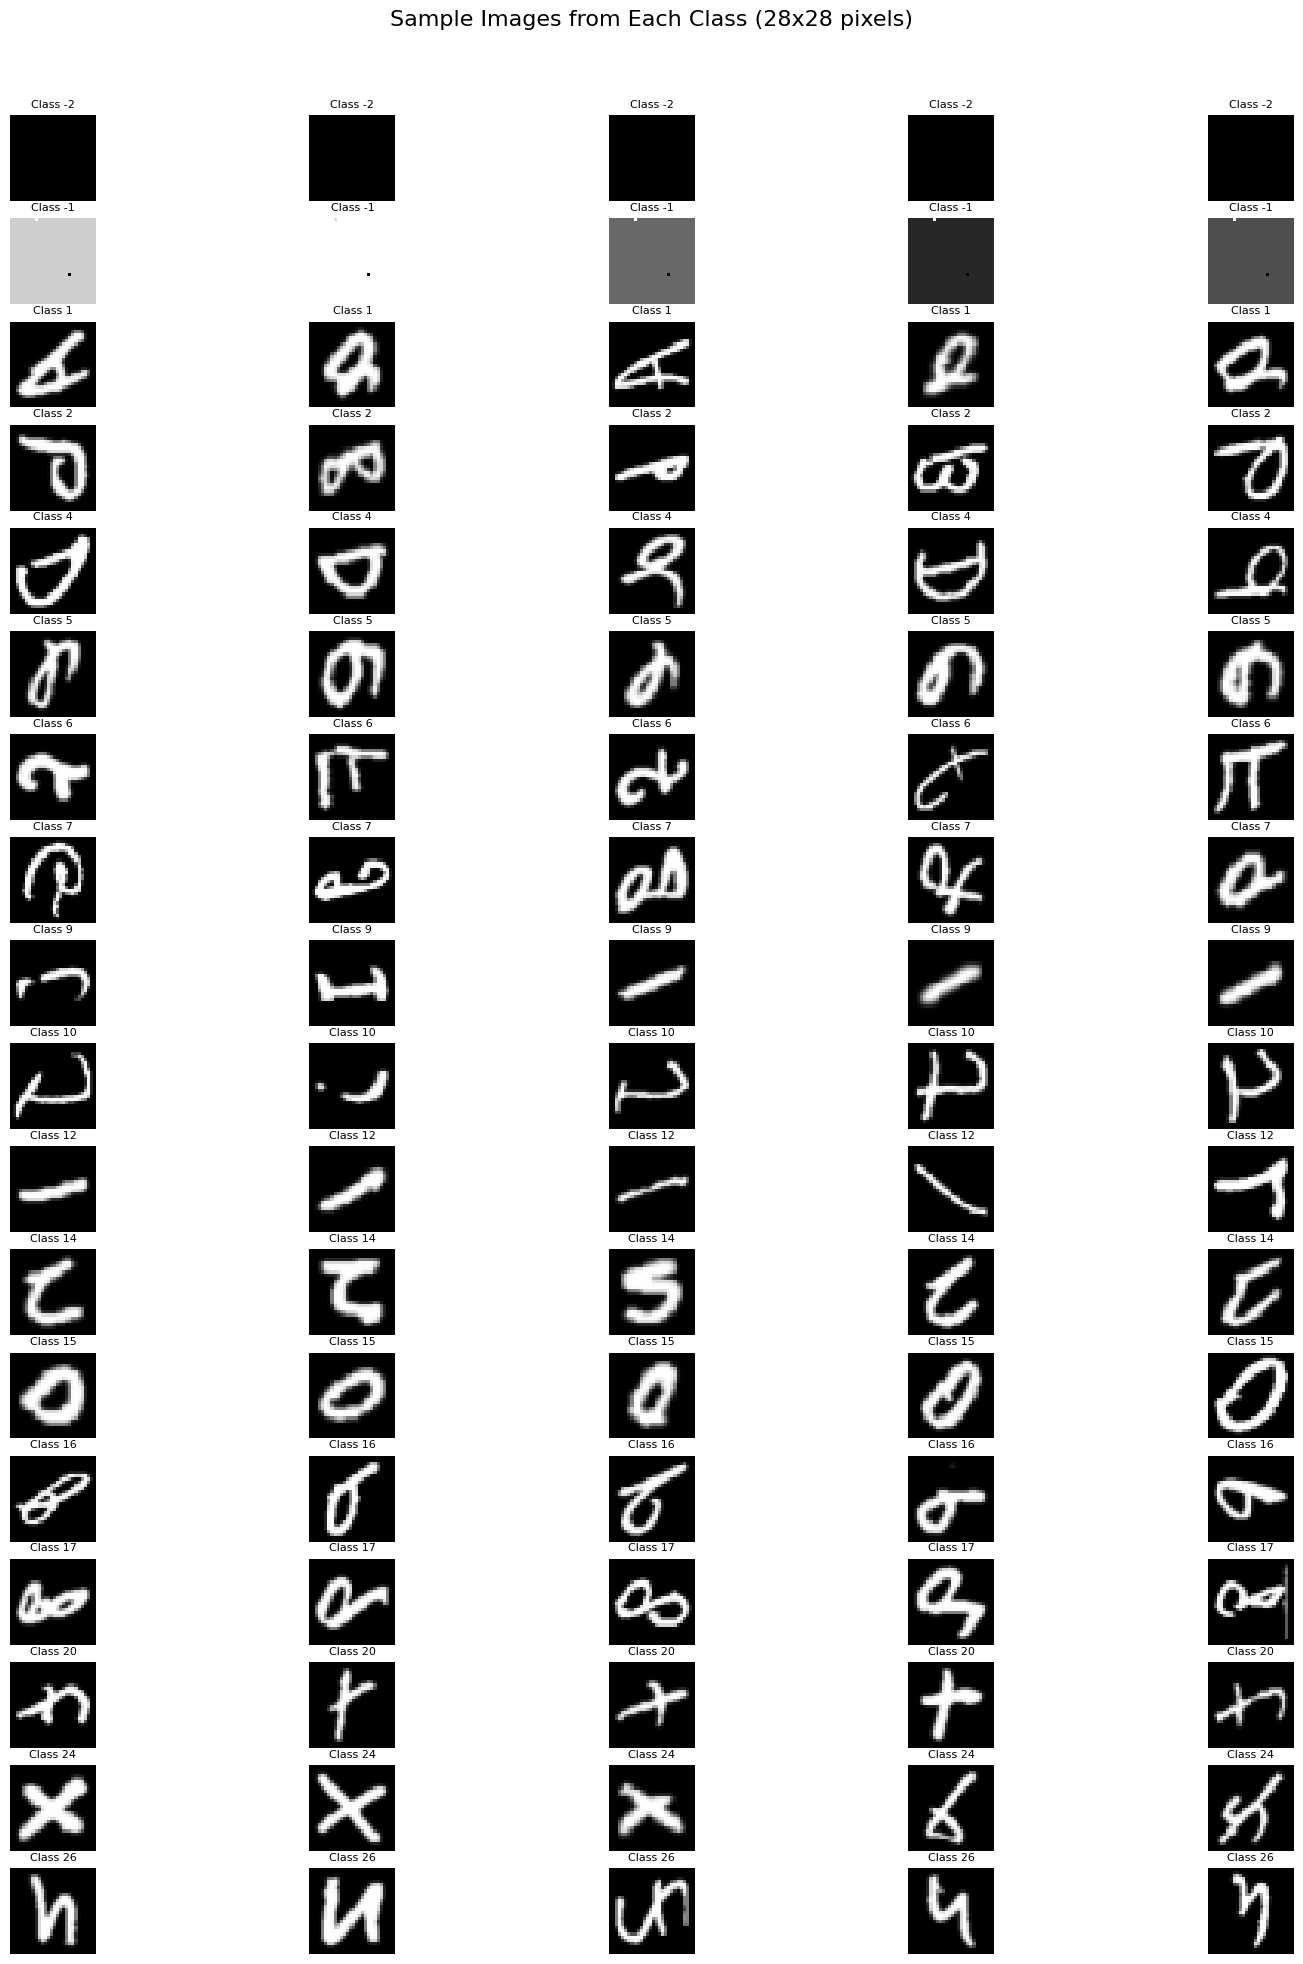

In [3]:
# Visualize sample images from different classes
def visualize_samples(data, n_samples=5, figsize=(15, 20)):
    """Visualize random samples from each class"""
    if 'label' not in data.columns:
        print("Label column not found")
        return

    unique_labels = sorted(data['label'].unique())
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)
    fig.suptitle(f'Sample Images from Each Class (28x28 pixels)', fontsize=16)

    for i, label in enumerate(unique_labels):
        class_data = data[data['label'] == label]
        samples = class_data.sample(n=min(n_samples, len(class_data)))

        for j in range(n_samples):
            if j < len(samples):
                # Get pixel values (excluding the label column)
                pixel_values = samples.iloc[j, 1:].values
                # Reshape to 28x28 image
                image = pixel_values.reshape(28, 28)

                if n_classes == 1:
                    axes[j].imshow(image, cmap='gray')
                    axes[j].set_title(f'Class {label}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[i, j].imshow(image, cmap='gray')
                    if j == 0:
                        axes[i, j].set_ylabel(f'Class {label}', fontsize=10)
                    axes[i, j].set_title(f'Class {label}', fontsize=8)
                    axes[i, j].axis('off')
            else:
                if n_classes == 1:
                    axes[j].axis('off')
                else:
                    axes[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

# Visualize samples
visualize_samples(data, n_samples=5)


#### Observations
After visualizing the dataset, we made the following key observations:

1. **Blank Classes**  
   - **Class -1** and **Class -2** contain only blank images.  
   - These classes are **not useful** for model training and will be **removed** from the dataset.

2. **Label Mapping**  
   - The remaining class labels start from `1` and follow **alphabetical order**, but not sequential, i.e.,  
     - Class `1` = `A`  
     - Class `2` = `B`, and `C` was skipped
     - Class `3` = `D`  
     - ... and so on.

3. **Mirrored Images**  
   - The characters appear to be **mirrored** (flipped horizontally).  
   - This needs to be corrected for accurate training.

---

#### Preprocessing & Augmentation Plan

To prepare the dataset for model training, we will apply the following steps:

1. **Remove Blank Images**  
   - Drop all entries with class `-1` and `-2`.

2. **Fix Image Orientation**  
   - Horizontally flip all images to correct the mirrored effect.

3. **Augment the Dataset**  
   - Apply data augmentation techniques to increase dataset robustness:
     - Random rotation
     - Slight scaling
     - Translation
     - Noise injection
     - Inversion (if applicable)

These steps will help ensure our model receives clean, diverse, and correctly labeled input data.


=== DATA CLEANING AND PREPROCESSING ===
Original dataset shape: (64829, 785)

1. Removing blank classes (-1 and -2)...
   Class -1: 5384 samples (to be removed)
   Class -2: 4856 samples (to be removed)
   Dataset shape after removing blank classes: (54589, 785)

2. Fixing image orientation (horizontal flip)...
   Applying horizontal flip to all images...

3. Creating proper label mapping...
   Remaining classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(20), np.int64(24), np.int64(26)]
   Label to Letter mapping: {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

4. Visualizing samples after preprocessing...


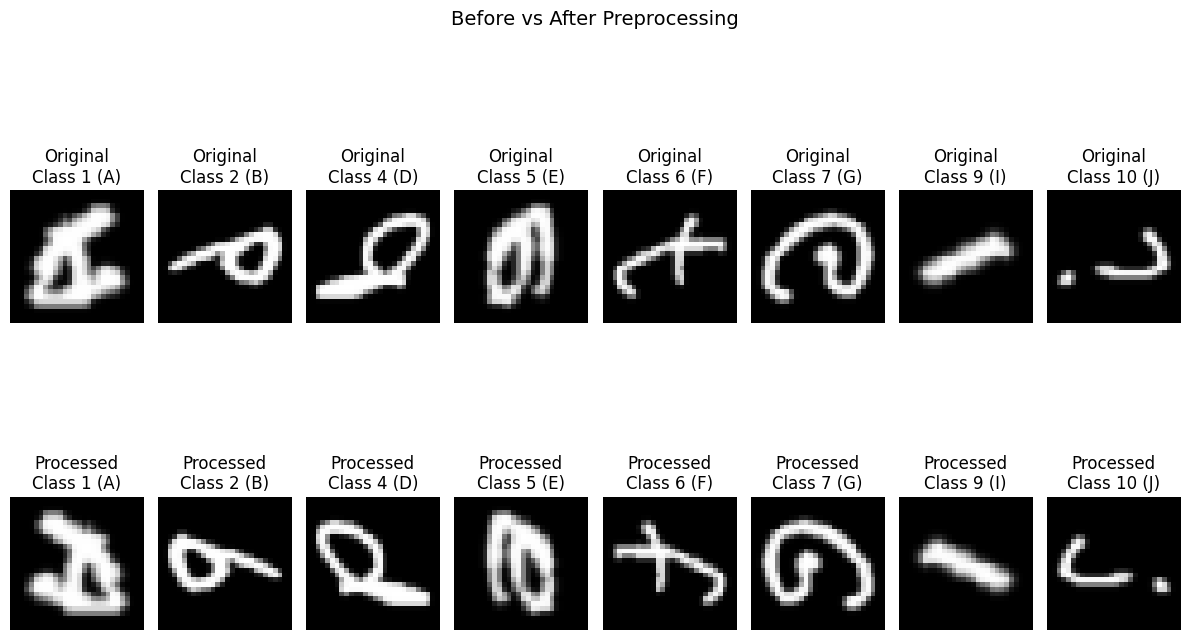


5. Final dataset statistics:
   Final dataset shape: (54589, 785)
   Number of classes: 16
   Classes removed: [-1, -2]
   Images per class:
     Class 1 (A): 3396 samples
     Class 2 (B): 3396 samples
     Class 4 (D): 3398 samples
     Class 5 (E): 3437 samples
     Class 6 (F): 3394 samples
     Class 7 (G): 3385 samples
     Class 9 (I): 3428 samples
     Class 10 (J): 3402 samples
     Class 12 (L): 3415 samples
     Class 14 (N): 3365 samples
     Class 15 (O): 3408 samples
     Class 16 (P): 3430 samples
     Class 17 (Q): 3435 samples
     Class 20 (T): 3436 samples
     Class 24 (X): 3437 samples
     Class 26 (Z): 3427 samples


In [4]:
# Data Cleaning and Preprocessing
def clean_and_preprocess_dataset(data):
    """Clean the dataset by removing blank classes and fixing image orientation"""

    print("=== DATA CLEANING AND PREPROCESSING ===")
    print(f"Original dataset shape: {data.shape}")

    # 1. Remove blank classes (-1 and -2)
    print(f"\n1. Removing blank classes (-1 and -2)...")
    blank_classes = [-1, -2]

    # Show samples before removal
    for blank_class in blank_classes:
        count = len(data[data['label'] == blank_class])
        print(f"   Class {blank_class}: {count} samples (to be removed)")

    # Remove blank classes
    cleaned_data = data[~data['label'].isin(blank_classes)].copy()
    print(f"   Dataset shape after removing blank classes: {cleaned_data.shape}")

    # 2. Fix image orientation (horizontal flip)
    print(f"\n2. Fixing image orientation (horizontal flip)...")

    # Extract pixel columns
    pixel_columns = [col for col in cleaned_data.columns if col.startswith('pixel_')]

    # Function to flip image horizontally
    def flip_image_horizontal(pixel_row):
        # Reshape to 28x28, flip horizontally, then flatten back
        image = pixel_row.values.reshape(28, 28)
        flipped_image = np.fliplr(image)  # Flip left-right
        return flipped_image.flatten()

    # Apply horizontal flip to all images
    print("   Applying horizontal flip to all images...")
    flipped_pixels = cleaned_data[pixel_columns].apply(flip_image_horizontal, axis=1, result_type='expand')

    # Replace pixel columns with flipped versions
    cleaned_data[pixel_columns] = flipped_pixels

    # 3. Update label mapping for alphabetical order
    print(f"\n3. Creating proper label mapping...")

    # Get unique labels (should be 1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26)
    remaining_labels = sorted(cleaned_data['label'].unique())
    print(f"   Remaining classes: {remaining_labels}")

    # Create mapping to letters (A=1, B=2, C=3, etc., skipping missing letters)
    letter_mapping = {}
    for i in range(1, 27):
        letter = chr(ord('A') + i - 1)  # Convert to letters A, B, C, etc.
        letter_mapping[i] = letter

    print(f"   Label to Letter mapping: {letter_mapping}")

    # 4. Visualize samples after preprocessing
    print(f"\n4. Visualizing samples after preprocessing...")

    # Show before and after comparison for a few samples
    def compare_before_after(original_data, cleaned_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))
        fig.suptitle('Before vs After Preprocessing', fontsize=14)

        # Select samples that exist in both datasets
        common_labels = [label for label in remaining_labels[:n_samples]]

        for i, label in enumerate(common_labels):
            # Original (before cleaning)
            orig_sample = original_data[original_data['label'] == label].iloc[0]
            orig_pixels = orig_sample[pixel_columns].values.reshape(28, 28)

            # Cleaned (after preprocessing)
            clean_sample = cleaned_data[cleaned_data['label'] == label].iloc[0]
            clean_pixels = clean_sample[pixel_columns].values.reshape(28, 28)

            # Plot original
            axes[0, i].imshow(orig_pixels, cmap='gray')
            axes[0, i].set_title(f'Original\nClass {label} ({letter_mapping[label]})')
            axes[0, i].axis('off')

            # Plot cleaned
            axes[1, i].imshow(clean_pixels, cmap='gray')
            axes[1, i].set_title(f'Processed\nClass {label} ({letter_mapping[label]})')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_before_after(data, cleaned_data, n_samples=8)

    # 5. Final statistics
    print(f"\n5. Final dataset statistics:")
    print(f"   Final dataset shape: {cleaned_data.shape}")
    print(f"   Number of classes: {len(remaining_labels)}")
    print(f"   Classes removed: {blank_classes}")
    print(f"   Images per class:")

    class_distribution = cleaned_data['label'].value_counts().sort_index()
    for label, count in class_distribution.items():
        letter = letter_mapping[label]
        print(f"     Class {label} ({letter}): {count} samples")

    # map labels to letters
    cleaned_data['label'] = cleaned_data['label'].map(letter_mapping)

    return cleaned_data, letter_mapping

# Apply cleaning and preprocessing
cleaned_data, letter_mapping = clean_and_preprocess_dataset(data)

#### After Preprocessing Observation

After applying the initial preprocessing steps (horizontal flipping and relabeling the classes), we made an additional observation:

- **Rotated Letters**  
  - All the characters are still **rotated sideways**.
  - To correct this, we need to **rotate each image by 90 degrees anti-clockwise** so that the letters are properly upright.

---

#### Updated Preprocessing Steps

1. **Remove Blank Images** (`Class -1` and `Class -2`)
2. **Relabel Classes** (Class `1` = `A`, Class `2` = `B`, ...)
3. **Flip Images Horizontally** (to fix mirrored effect)
4. **Rotate Images 90° Anti-Clockwise** (to orient characters correctly)

This ensures the images are in the correct visual format before we apply any further augmentation or training.


=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===
Dataset shape before rotation: (54589, 785)
   Applying 90° anti-clockwise rotation to all images...
   Visualizing before vs after rotation...


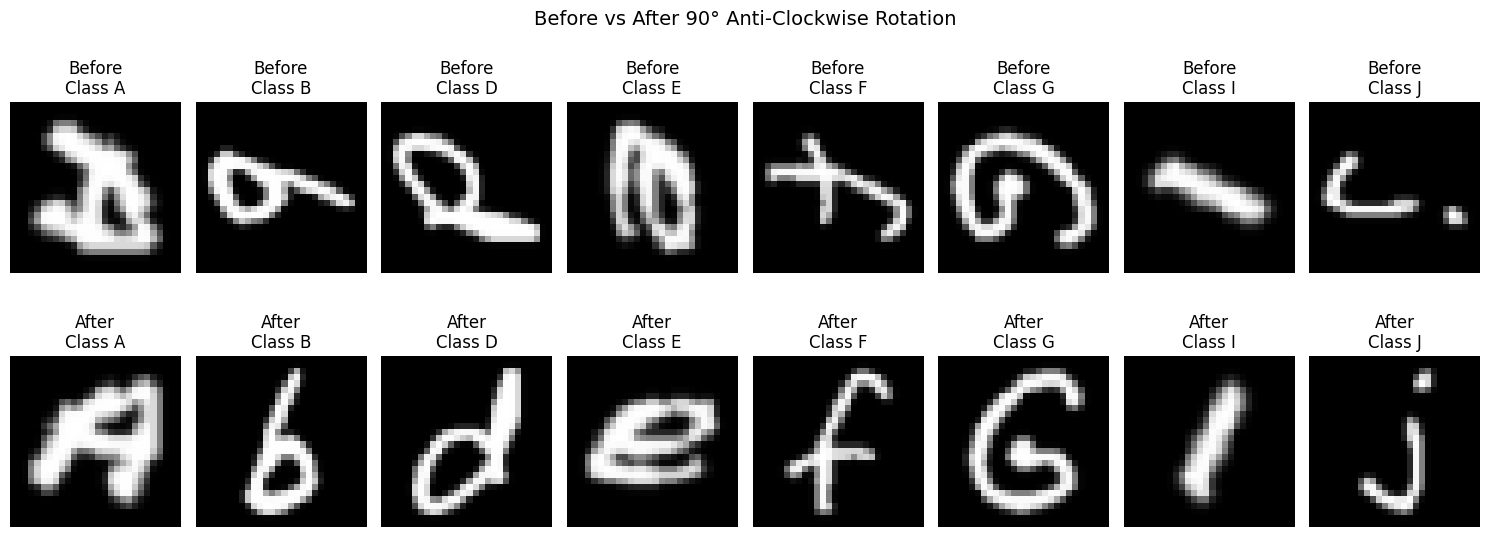

   Final dataset shape after rotation: (54589, 785)
   Rotation completed successfully!


In [5]:
# Rotate all images 90 degrees anti-clockwise
def rotate_images_90_anticlockwise(data):
    """Rotate all images in the dataset 90 degrees anti-clockwise"""

    print("=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===")
    print(f"Dataset shape before rotation: {data.shape}")

    # Extract pixel columns
    pixel_columns = [col for col in data.columns if col.startswith('pixel_')]

    def rotate_image_90_anticlockwise(pixel_row):
        # Reshape to 28x28, rotate 90° anti-clockwise, then flatten back
        image = pixel_row.values.reshape(28, 28)
        rotated_image = np.rot90(image, k=1)  # k=1 means 90° counter-clockwise
        return pd.Series(rotated_image.flatten())

    # Apply rotation to all images
    print("   Applying 90° anti-clockwise rotation to all images...")
    rotated_pixels = data[pixel_columns].apply(rotate_image_90_anticlockwise, axis=1, result_type='expand')
    rotated_pixels = rotated_pixels.astype(np.float32)  # Ensure pixel values are float32

    # Create a copy of the data and replace pixel columns with rotated versions
    rotated_data = data.copy()
    rotated_data[pixel_columns] = rotated_pixels

    # Visualize before and after comparison
    print("   Visualizing before vs after rotation...")

    def compare_rotation(original_data, rotated_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
        fig.suptitle('Before vs After 90° Anti-Clockwise Rotation', fontsize=14)

        # Select sample labels to visualize
        sample_labels = sorted(original_data['label'].unique())[:n_samples]

        for i, label in enumerate(sample_labels):
            if label in original_data['label'].values:
                # Original (before rotation)
                orig_sample = original_data[original_data['label'] == label].iloc[0]
                orig_pixels = orig_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Rotated (after rotation)
                rot_sample = rotated_data[rotated_data['label'] == label].iloc[0]
                rot_pixels = rot_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Plot original
                axes[0, i].imshow(orig_pixels, cmap='gray')
                axes[0, i].set_title(f'Before\nClass {label}')
                axes[0, i].axis('off')

                # Plot rotated
                axes[1, i].imshow(rot_pixels, cmap='gray')
                axes[1, i].set_title(f'After\nClass {label}')
                axes[1, i].axis('off')
            else:
                axes[0, i].axis('off')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_rotation(data, rotated_data, n_samples=8)

    print(f"   Final dataset shape after rotation: {rotated_data.shape}")
    print("   Rotation completed successfully!")

    return rotated_data

# Apply rotation to the cleaned data
rotated_data = rotate_images_90_anticlockwise(cleaned_data)



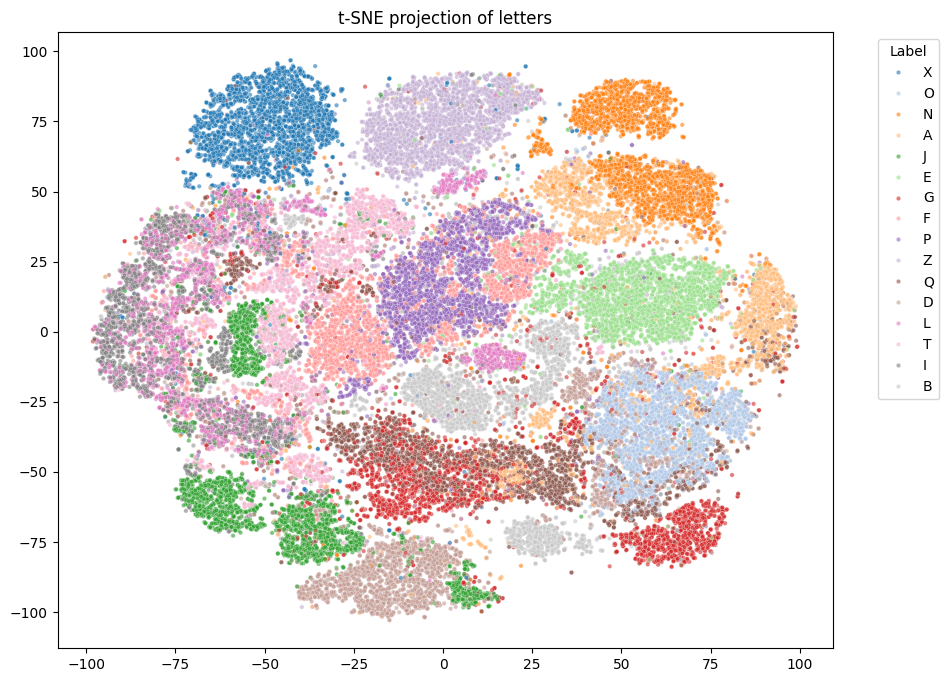

In [6]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
pixel_columns = [f'pixel_{i}' for i in range(784)]
# Flatten pixel data
X_flat = rotated_data[pixel_columns].values
labels = rotated_data['label'].values

# Reduce to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab20', s=10, alpha=0.6)
plt.title("t-SNE projection of letters")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Outliers detection with TSNE and DBSCAN

In [7]:
# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Prepare t-SNE input
# X_flat = rotated_data[pixel_columns].values
# labels = rotated_data['label'].values

# # Run t-SNE on entire dataset
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_flat)

# # Attach t-SNE results to dataframe
# rotated_data['tsne_x'] = X_tsne[:, 0]
# rotated_data['tsne_y'] = X_tsne[:, 1]

# # Store suspected outliers
# outlier_rows = []
# tsne_outlier_indices_by_label = {}

# # For each label, cluster in t-SNE space
# for label in np.unique(labels):
#     subset = rotated_data[rotated_data['label'] == label]
#     coords = subset[['tsne_x', 'tsne_y']].values

#     # DBSCAN: density-based clustering
#     dbscan = DBSCAN(eps=5.0, min_samples=10)
#     cluster_labels = dbscan.fit_predict(coords)

#     # Add cluster labels
#     subset = subset.copy()
#     subset['tsne_cluster'] = cluster_labels

#     # Select outliers: cluster == -1 or rare clusters
#     cluster_counts = subset['tsne_cluster'].value_counts()
#     rare_clusters = cluster_counts[cluster_counts < 15].index
#     is_outlier = subset['tsne_cluster'].isin(rare_clusters)
#     outliers = subset[is_outlier]

#     outlier_rows.append(outliers)
#     print(f"Label {label}: Found {len(outliers)} potential outliers")

# # Combine all outliers
# all_tsne_outliers = pd.concat(outlier_rows, ignore_index=False) if outlier_rows else pd.DataFrame()

# print(f"\n=== t-SNE + DBSCAN: VISUALIZING ALL {len(all_tsne_outliers)} OUTLIERS ===")

# # Visualization function: show original index in full dataset
# def visualize_all_outliers_tsne(df, pixel_columns, max_per_row=10):
#     if df.empty:
#         print("No outliers found!")
#         return

#     labels = sorted(df['label'].unique())

#     for label in labels:
#         subset = df[df['label'] == label]
#         if len(subset) == 0:
#             continue

#         print(f"\nLabel {label}: {len(subset)} outliers")

#         # Grid dimensions
#         n_outliers = len(subset)
#         n_rows = (n_outliers + max_per_row - 1) // max_per_row
#         n_cols = min(max_per_row, n_outliers)

#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

#         # Normalize axes structure
#         if n_rows == 1 and n_cols == 1:
#             axes = np.array([[axes]])
#         elif n_rows == 1:
#             axes = np.array([axes])
#         elif n_cols == 1:
#             axes = axes.reshape(-1, 1)

#         for i, (idx, row) in enumerate(subset.iterrows()):
#             row_idx = i // max_per_row
#             col_idx = i % max_per_row
#             ax = axes[row_idx, col_idx]

#             img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)
#             ax.imshow(img, cmap='gray')
#             ax.set_title(f"Idx {idx}", fontsize=8)
#             ax.axis('off')

#         # Hide any empty subplots
#         total_subplots = n_rows * n_cols
#         for i in range(n_outliers, total_subplots):
#             row_idx = i // max_per_row
#             col_idx = i % max_per_row
#             axes[row_idx, col_idx].axis('off')

#         plt.suptitle(f"t-SNE + DBSCAN: ALL Outliers for Label {label}", fontsize=14)
#         plt.tight_layout()
#         plt.show()

# # Visualize
# visualize_all_outliers_tsne(all_tsne_outliers, pixel_columns)


### Outliers detection with IsolationForest


Anomaly Detection: Isolation-based Approach

This method focuses on identifying anomalies based on how easily they can be "isolated" from the rest of the data points.

* **Global Approach:** The algorithm operates directly on the raw data in its full 784-dimensional pixel space, without any dimensionality reduction. This makes it a "global" approach, considering all features simultaneously.

* **Contamination Parameter:** We assume that **1% of the data are outliers**, which is specified by the `contamination` parameter set to `0.01`. This value helps the model to set a threshold for what constitutes an anomaly.

* **Efficiency:** The key advantage of this method is its speed. It's **faster** than many other techniques because it doesn't require any time-consuming dimensionality reduction steps.

In [8]:
# from sklearn.ensemble import IsolationForest
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to find ALL outliers and visualize them
# def find_and_visualize_all_outliers_iso(data, pixel_columns, contamination=0.01, max_per_row=10):
#     outlier_indices_by_label = {}
#     labels = sorted(data['label'].unique())

#     print(f"=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===")

#     for label in labels:
#         subset = data[data['label'] == label]
#         X = subset[pixel_columns].values.astype(np.float32)

#         # Use IsolationForest to detect outliers
#         iso = IsolationForest(contamination=contamination, random_state=42)
#         preds = iso.fit_predict(X)
#         outlier_mask = preds == -1
#         outlier_indices = subset.index[outlier_mask].tolist()
#         outlier_indices_by_label[label] = outlier_indices

#         print(f"Label {label}: Found {len(outlier_indices)} outliers out of {len(subset)} samples.")

#         # Visualize ALL outliers for this label
#         if len(outlier_indices) > 0:
#             outlier_data = subset.loc[outlier_indices]

#             # Calculate grid dimensions
#             n_outliers = len(outlier_data)
#             n_rows = (n_outliers + max_per_row - 1) // max_per_row
#             n_cols = min(max_per_row, n_outliers)

#             fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

#             # Handle single row/column cases
#             if n_rows == 1 and n_cols == 1:
#                 axes = [axes]
#             elif n_rows == 1:
#                 axes = axes.reshape(1, -1)
#             elif n_cols == 1:
#                 axes = axes.reshape(-1, 1)

#             # Plot each outlier
#             for i, (_, row) in enumerate(outlier_data.iterrows()):
#                 row_idx = i // max_per_row
#                 col_idx = i % max_per_row

#                 img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)

#                 if n_rows == 1:
#                     ax = axes[col_idx]
#                 else:
#                     ax = axes[row_idx, col_idx]

#                 ax.imshow(img, cmap='gray')
#                 ax.set_title(f"Idx {row.name}", fontsize=8)
#                 ax.axis('off')

#             # Hide unused subplots
#             total_subplots = n_rows * n_cols
#             for i in range(n_outliers, total_subplots):
#                 row_idx = i // max_per_row
#                 col_idx = i % max_per_row
#                 if n_rows == 1:
#                     axes[col_idx].axis('off')
#                 else:
#                     axes[row_idx, col_idx].axis('off')

#             plt.suptitle(f"Isolation Forest: ALL Outliers for Label {label}", fontsize=14)
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"No outliers to visualize for label {label}")

#     return outlier_indices_by_label

# # Run outlier detection and visualize ALL outliers
# iso_outlier_indices = find_and_visualize_all_outliers_iso(rotated_data, pixel_columns, contamination=0.01)

# # Print summary
# total_iso_outliers = sum(len(indices) for indices in iso_outlier_indices.values())
# print(f"\nTotal Isolation Forest outliers: {total_iso_outliers}")

From visual inspection, we will remove the images, that are too noisy, and move some to correct class.

In [9]:
# Function to remove outliers and update class labels
def process_outliers(data, outliers_to_remove, updates_to_classes):
    """
    Removes specified rows (outliers) and updates labels of specific rows.

    Args:
        data (pd.DataFrame): The dataset to process.
        outliers_to_remove (list): List of indices to remove from the dataset.
        updates_to_classes (dict): Dictionary mapping indices to new class labels.

    Returns:
        pd.DataFrame: The processed dataset.
    """
    print(f"Original dataset shape: {data.shape}")

    # Remove specified outlier rows
    print(f"Removing {len(outliers_to_remove)} rows...")
    data = data.drop(index=outliers_to_remove, errors='ignore')
    print(f"Dataset shape after removal: {data.shape}")

    # Update specified rows to new class labels
    print(f"Updating {len(updates_to_classes)} rows to new labels...")
    for idx, new_label in updates_to_classes.items():
        if idx in data.index:
            data.at[idx, 'label'] = new_label
    print("Label updates completed.")

    return data

# Outliers to remove
outliers_to_remove = [
    5362, 8105, 32140, 30073, 40199, 40364, 49327, 54408, 54665, 56188, 60695, 2424, 3568, 59481, 43186, 48902, 256,
    4249, 6879, 9001, 17046, 32857, 29673, 26107, 35297, 40375, 41278, 44397, 47035, 50432, 50702, 55808, 64400, 18220,
    47810, 51376, 1266, 1647, 13929, 18368, 18411, 21182, 36521, 46041, 52252, 57499, 12751, 3268, 15145, 30626, 44091,
    58212, 9300, 19117, 26187, 26374, 28260, 1388, 11830, 17078, 19585, 19723, 24231, 42125, 3422, 31606, 4208, 6942,
    26121, 41075, 41398, 1041, 32965, 4453, 6936, 13417, 18385, 25194, 27321, 30821, 34134, 34346, 40403, 52909, 58284,
    59675, 61653, 3115, 9284, 20048, 26066, 53852, 8874, 21936, 22151, 54099, 54738, 19940, 22261, 24282, 35728, 37168,
    37701, 37794, 39589, 40233, 57717, 43926, 37338, 17360, 5671, 21688, 64765, 13445, 19584, 20131, 45410, 50703, 61004,
    63433, 12645
]

# Rows to update to new class labels
updates_to_classes = {
    7596: 'A',
    11873: 'D',
    13170: 'E',
    34881: 'E',
    22261: 'O',
    59806: 'B'
}

# Apply the processing function
processed_data = process_outliers(rotated_data, outliers_to_remove, updates_to_classes)

# Summary of changes
print(f"\nProcessed dataset shape: {processed_data.shape}")
print("Changes applied successfully!")

Original dataset shape: (54589, 785)
Removing 121 rows...
Dataset shape after removal: (54468, 785)
Updating 6 rows to new labels...
Label updates completed.

Processed dataset shape: (54468, 785)
Changes applied successfully!


In [10]:
# # Step 1: Copy original dataset to preserve it
# no_outlier_data = rotated_data.copy()

# # Step 2: Manually remove selected t-SNE outliers
# manual_tsne_removals = [2, 5, 15, 19, 27, 30, 32, 45, 46, 71, 76, 95, 102, 127, 129,
#                         139, 140, 158, 207, 221, 222, 225, 227, 246, 250, 252, 265, 266, 267]
# no_outlier_data = no_outlier_data.drop(index=manual_tsne_removals, errors='ignore')

# # Step 3: Run Isolation Forest to detect and collect outlier indices
# iso_outlier_indices = find_and_visualize_all_outliers_iso(rotated_data, pixel_columns, contamination=0.01)

# # Step 4: Flatten all Isolation Forest outlier indices into a single set
# iso_outlier_set = set()
# for idx_list in iso_outlier_indices.values():
#     iso_outlier_set.update(idx_list)

# # Step 5: Remove all Isolation Forest outliers from no_outlier_data
# no_outlier_data = no_outlier_data.drop(index=iso_outlier_set, errors='ignore')

# # Step 6: Apply specific relabeling
# no_outlier_data.loc[168, 'label'] = 0           # Move to class 'A' (label 0)
# no_outlier_data.loc[13170, 'label'] = 'E'       # Move to class 'E'
# no_outlier_data.loc[59806, 'label'] = 'B'       # Move to class 'B'

# # Step 7: (Optional) Reset index for easier access
# no_outlier_data = no_outlier_data.reset_index(drop=True)

# # Step 8: (Optional) Save cleaned version
# # no_outlier_data.to_csv('emnist_cleaned.csv', index=False)

# # Done
# print(f"Cleaned dataset ready: {len(no_outlier_data)} samples remaining.")


### Seperating Upper and Lower-case Letters
---

In [11]:
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Columns containing pixel values
# pixel_columns = [col for col in rotated_data.columns if col.startswith('pixel_')]

# # Unique class labels (e.g., 1 for A, 2 for B, ...)
# class_labels = rotated_data['label'].unique()
# class_labels.sort()

# # Store clustered data
# clustered_results = []

# for class_id in class_labels:
#     # Subset to current class
#     class_data = rotated_data[rotated_data['label'] == class_id].copy()

#     # Get flattened pixel values
#     X_flat = class_data[pixel_columns].values

#     # Dimensionality reduction using PCA
#     pca = PCA(n_components=50, random_state=42)
#     X_pca = pca.fit_transform(X_flat)

#     # Gaussian Mixture Model (2 clusters)
#     gmm = GaussianMixture(n_components=2, random_state=42)
#     clusters = gmm.fit_predict(X_pca)

#     # Save subcluster label
#     class_data['subcluster'] = clusters

#     # Show cluster counts
#     print(f"Class {class_id}:")
#     print(class_data['subcluster'].value_counts())

#     # Visualize a few samples from each subcluster
#     def show_cluster_samples(data, cluster_label, class_id, n_samples=6):
#         samples = data[data['subcluster'] == cluster_label].sample(n=n_samples, random_state=42)
#         fig, axes = plt.subplots(1, n_samples, figsize=(12, 2))
#         for i, (_, row) in enumerate(samples.iterrows()):
#             img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)
#             axes[i].imshow(img, cmap='gray')
#             axes[i].axis('off')
#         plt.suptitle(f"Class {class_id} - Cluster {cluster_label}")
#         plt.show()

#     show_cluster_samples(class_data, 0, class_id)
#     show_cluster_samples(class_data, 1, class_id)

#     # Append this class's data with subclusters
#     clustered_results.append(class_data)

# # Combine all class-clustered data into one dataframe
# final_clustered_data = pd.concat(clustered_results, ignore_index=True)


## GAN Implementation
---

### Data Preprocessing for GAN Training
---
Let's prepare the data for GAN training by normalizing and reshaping the images.

In [12]:
rotated_data

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64823,Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64825,P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64826,B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64827,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def preprocess_data_basic_gan(data):
    """Preprocess the dataset for Basic GAN training."""
    # Extract pixel data (skip labels)
    pixels = data.iloc[:, 1:].values

    # Reshape to 28x28 images and normalize to [-1, 1]
    images = pixels.reshape(-1, 28, 28)
    images = (images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

    # Add channel dimension for compatibility with CNN layers
    images = np.expand_dims(images, axis=-1)

    print(f"Images shape: {images.shape}")
    print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")

    return images

# Preprocess the data for Basic GAN
X_train_gan = preprocess_data_basic_gan(rotated_data)

Images shape: (54589, 28, 28, 1)
Images range: [-1.000, 1.000]


### 3. GAN Training Implementation
---
Let's implement the training loop for our conditional GAN.

In [14]:
class BasicGAN:
    def __init__(self, img_shape=(28, 28, 1), latent_dim=100):
        """
        Initialize Basic GAN components: generator and discriminator.
        Args:
            img_shape (tuple): Shape of input images (28x28 grayscale).
            latent_dim (int): Dimensionality of the random noise vector.
        """
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Build generator and discriminator models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Optimizers for training
        self.gen_optimizer = optimizers.Adam(1e-4)
        self.disc_optimizer = optimizers.Adam(1e-4)

        # Track losses for visualization
        self.d_losses = []
        self.g_losses = []

    def build_generator(self):
        """
        Build the generator model.
        Returns:
            tf.keras.Model: Generator model that takes noise as input and outputs synthetic images.
        """
        noise_input = layers.Input(shape=(self.latent_dim,))

        # Dense layer to project noise into feature maps
        x = layers.Dense(7 * 7 * 256, use_bias=False)(noise_input)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Reshape projected features to spatial dimensions
        x = layers.Reshape((7, 7, 256))(x)

        # Deconvolutional layers to upsample
        x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Final layer to output a single channel grayscale image
        x = layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

        return models.Model(noise_input, x)

    def build_discriminator(self):
        """
        Build the discriminator model.
        Returns:
            tf.keras.Model: Discriminator model that takes images as input and outputs a binary classification.
        """
        image_input = layers.Input(shape=self.img_shape)

        # Convolutional layers to downsample
        x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(image_input)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        # Flatten the spatial dimensions and output binary classification
        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)

        return models.Model(image_input, x)

    def discriminator_loss(self, real_output, fake_output):
        """
        Calculate discriminator loss.
        Args:
            real_output: Discriminator output for real images
            fake_output: Discriminator output for fake images
        Returns:
            tf.Tensor: Discriminator loss
        """
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        """
        Calculate generator loss.
        Args:
            fake_output: Discriminator output for fake images
        Returns:
            tf.Tensor: Generator loss
        """
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

### 4. GAN Training and Generation
---
Let's train our GAN and generate the required 160 images (10 per class for 16 classes).

In [15]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
# import matplotlib.pyplot as plt
# import numpy as np



# class BasicGANTrainer:
#     def __init__(self, gan, train_dataset, latent_dim=100):
#         """
#         Initialize the GAN trainer.
#         Args:
#             gan (BasicGAN): The GAN model containing generator and discriminator.
#             train_dataset (tf.data.Dataset): Dataset of real images for training.
#             latent_dim (int): Dimensionality of the random noise vector.
#         """
#         self.gan = gan
#         self.train_dataset = train_dataset
#         self.latent_dim = latent_dim

#     def train_step(self, images):
#         """
#         A single training step for GAN.
#         Args:
#             images (tf.Tensor): Batch of real images from the dataset.
#         Returns:
#             tuple: Discriminator and generator losses.
#         """
#         noise = tf.random.normal([images.shape[0], self.latent_dim])

#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = self.gan.generator(noise, training=True)
#             real_output = self.gan.discriminator(images, training=True)
#             fake_output = self.gan.discriminator(generated_images, training=True)
#             g_loss = self.gan.generator_loss(fake_output)
#             d_loss = self.gan.discriminator_loss(real_output, fake_output)

#         gradients_gen = gen_tape.gradient(g_loss, self.gan.generator.trainable_variables)
#         gradients_disc = disc_tape.gradient(d_loss, self.gan.discriminator.trainable_variables)

#         self.gan.gen_optimizer.apply_gradients(zip(gradients_gen, self.gan.generator.trainable_variables))
#         self.gan.disc_optimizer.apply_gradients(zip(gradients_disc, self.gan.discriminator.trainable_variables))

#         return d_loss, g_loss

#     def train(self, epochs=30, sample_interval=5):
#         """
#         Train the GAN for a specified number of epochs.
#         Args:
#             epochs (int): Number of epochs for training.
#             sample_interval (int): Interval for sampling and visualizing generated images.
#         """
#         fixed_noise = tf.random.normal([16, self.latent_dim])

#         for epoch in range(epochs):
#             for batch_images in self.train_dataset:
#                 d_loss, g_loss = self.train_step(batch_images)

#             self.gan.d_losses.append(d_loss.numpy())
#             self.gan.g_losses.append(g_loss.numpy())

#             if (epoch + 1) % sample_interval == 0 or epoch == 0:
#                 print(f"Epoch {epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
#                 self.sample_images(epoch, fixed_noise)

#     def sample_images(self, epoch, noise):
#         """
#         Generate and visualize a batch of images during training.
#         Args:
#             epoch (int): Current epoch number.
#             noise (tf.Tensor): Noise vector for the generator.
#         """
#         gen_imgs = self.gan.generator(noise, training=False)
#         gen_imgs = (gen_imgs + 1) / 2.0  # Rescale [-1, 1] to [0, 1]

#         fig, axs = plt.subplots(4, 4, figsize=(8, 8))
#         cnt = 0
#         for i in range(4):
#             for j in range(4):
#                 axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#                 axs[i, j].axis('off')
#                 cnt += 1
#         plt.suptitle(f"Generated Images at Epoch {epoch+1}")
#         plt.tight_layout()
#         plt.show()


# # Hyperparameters
# BATCH_SIZE = 256
# BUFFER_SIZE = len(X_train_gan)

# # Create TensorFlow dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(X_train_gan)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# # Initialize the GAN
# gan = BasicGAN(img_shape=(28, 28, 1), latent_dim=100)

# # Initialize the trainer
# trainer = BasicGANTrainer(gan, train_dataset, latent_dim=100)

# # Train the GAN
# trainer.train(epochs=50, sample_interval=5)

As observed, the imges are generated are not classified, in fact, because we are using GAN, which is unable to specify class of the image they produce, meaning we cannot guarantee that we will get images for all 16 classes, so we will find other type of GAN.

## CGAN Implementation
---

### Data Preprocessing for CGAN Training

First, we will have to process the data, so that it is ready to be fed into CGAN.

In [16]:
def preprocess_data_cgan(data):
    """
    Preprocess the EMNIST dataset for Conditional GAN (CGAN) training.

    Args:
        data (pd.DataFrame): Original dataset with labels and pixel values.

    Returns:
        tuple: Preprocessed images normalized to [-1, 1] and encoded labels.
    """
    # Separate labels and pixel data
    labels = data['label'].values
    pixels = data.iloc[:, 1:].values

    # Reshape to 28x28 images and normalize to [-1, 1]
    images = pixels.reshape(-1, 28, 28)
    images = (images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

    # Add a channel dimension for compatibility with CNN layers
    images = np.expand_dims(images, axis=-1)

    print(f"Images shape: {images.shape}")
    print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Unique labels: {sorted(np.unique(labels))}")

    # Create a mapping from original labels to sequential indices
    unique_labels = sorted(np.unique(labels))
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    labels_encoded = np.array([label_mapping[label] for label in labels])

    print(f"\nLabel mapping: {label_mapping}")
    print(f"Number of classes: {len(unique_labels)}")

    # Check class distribution
    class_counts = np.bincount(labels_encoded)
    print(f"\nClass distribution (encoded):")
    for i, count in enumerate(class_counts):
        print(f"Class {i} (original: {unique_labels[i]}): {count} samples")

    return images, labels_encoded, unique_labels, label_mapping

# Preprocess the data specifically for Conditional GAN
X_train_cgan, y_train_cgan, unique_labels_cgan, label_mapping_cgan = preprocess_data_cgan(rotated_data)

Images shape: (54589, 28, 28, 1)
Images range: [-1.000, 1.000]
Unique labels: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

Label mapping: {'A': 0, 'B': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'I': 6, 'J': 7, 'L': 8, 'N': 9, 'O': 10, 'P': 11, 'Q': 12, 'T': 13, 'X': 14, 'Z': 15}
Number of classes: 16

Class distribution (encoded):
Class 0 (original: A): 3396 samples
Class 1 (original: B): 3396 samples
Class 2 (original: D): 3398 samples
Class 3 (original: E): 3437 samples
Class 4 (original: F): 3394 samples
Class 5 (original: G): 3385 samples
Class 6 (original: I): 3428 samples
Class 7 (original: J): 3402 samples
Class 8 (original: L): 3415 samples
Class 9 (original: N): 3365 samples
Class 10 (original: O): 3408 samples
Class 11 (original: P): 3430 samples
Class 12 (original: Q): 3435 samples
Class 13 (original: T): 3436 samples
Class 14 (original: X): 3437 samples
Class 15 (original: Z): 3427 samples


### CGAN Training Implementation

In [17]:
class ConditionalGAN:
    def __init__(self, img_shape=(28, 28, 1), latent_dim=100, num_classes=26, embedding_dim=50):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Optimizers
        self.gen_optimizer = optimizers.Adam(1e-4)
        self.disc_optimizer = optimizers.Adam(1e-4)

        # Track losses
        self.d_losses = []
        self.g_losses = []

    def build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(1,), dtype='int32')

        label_embedding = layers.Embedding(self.num_classes, self.embedding_dim)(label_input)
        label_embedding = layers.Flatten()(label_embedding)
        x = layers.Concatenate()([noise_input, label_embedding])

        x = layers.Dense(7*7*256, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Reshape((7, 7, 256))(x)

        x = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

        return tf.keras.Model([noise_input, label_input], x)

    def build_discriminator(self):
        image_input = layers.Input(shape=self.img_shape)
        label_input = layers.Input(shape=(1,), dtype='int32')

        label_embedding = layers.Embedding(self.num_classes, np.prod(self.img_shape))(label_input)
        label_embedding = layers.Reshape(self.img_shape)(label_embedding)

        x = layers.Concatenate()([image_input, label_embedding])
        x = layers.Conv2D(64, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        x = layers.Dense(1)(x)

        return tf.keras.Model([image_input, label_input], x)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images, labels):
        noise = tf.random.normal([images.shape[0], self.latent_dim])
        gen_labels = tf.random.uniform([images.shape[0], 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator([noise, gen_labels], training=True)

            real_output = self.discriminator([images, tf.expand_dims(labels, axis=1)], training=True)
            fake_output = self.discriminator([generated_images, gen_labels], training=True)

            g_loss = self.generator_loss(fake_output)
            d_loss = self.discriminator_loss(real_output, fake_output)

        gradients_gen = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        gradients_disc = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gradients_gen, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_disc, self.discriminator.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        fixed_noise = tf.random.normal([16, self.latent_dim])
        fixed_labels = tf.constant([[i % self.num_classes] for i in range(16)], dtype=tf.int32)

        for epoch in range(epochs):
            for batch_images, batch_labels in dataset:
                d_loss, g_loss = self.train_step(batch_images, batch_labels)

            self.d_losses.append(d_loss.numpy())
            self.g_losses.append(g_loss.numpy())

            if (epoch + 1) % sample_interval == 0 or epoch == 0:
                print(f"Epoch {epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
                self.sample_images(epoch, fixed_noise, fixed_labels)

    def sample_images(self, epoch, noise, labels):
        gen_imgs = self.generator([noise, labels], training=False)
        gen_imgs = (gen_imgs + 1) / 2.0  # [-1, 1] -> [0, 1]

        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        cnt = 0
        for i in range(4):
            for j in range(4):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title(f"Class {labels[cnt].numpy()[0]}")
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"Generated Images at Epoch {epoch+1}")
        plt.tight_layout()
        plt.show()

    def generate_specific_class(self, class_label, num_samples=16):
        noise = tf.random.normal([num_samples, self.latent_dim])
        labels = tf.constant([[class_label]] * num_samples, dtype=tf.int32)
        gen_imgs = self.generator([noise, labels], training=False)
        gen_imgs = (gen_imgs + 1) / 2.0

        rows = int(np.sqrt(num_samples))
        cols = int(np.ceil(num_samples / rows))

        fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
        axs = axs.flatten()

        for i in range(num_samples):
            axs[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[i].set_title(f"Class {class_label}")
            axs[i].axis('off')
        for i in range(num_samples, len(axs)):
            axs[i].axis('off')

        plt.suptitle(f"Generated Samples for Class {class_label}")
        plt.tight_layout()
        plt.show()

        return gen_imgs

### CGAN Training and Generation

Epoch 1 [D loss: 0.9118] [G loss: 1.0002]


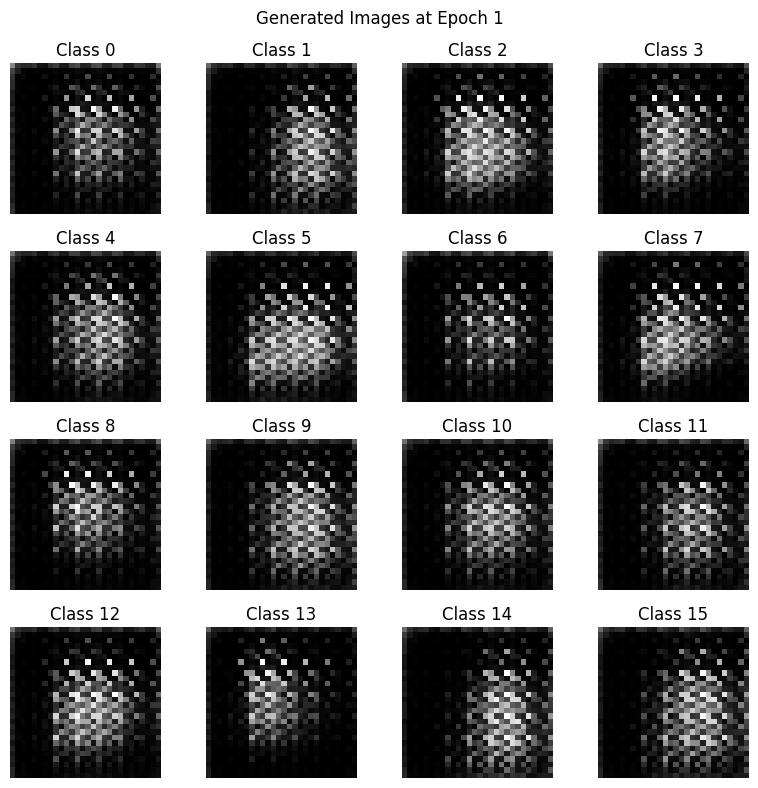

Epoch 5 [D loss: 1.1024] [G loss: 1.0735]


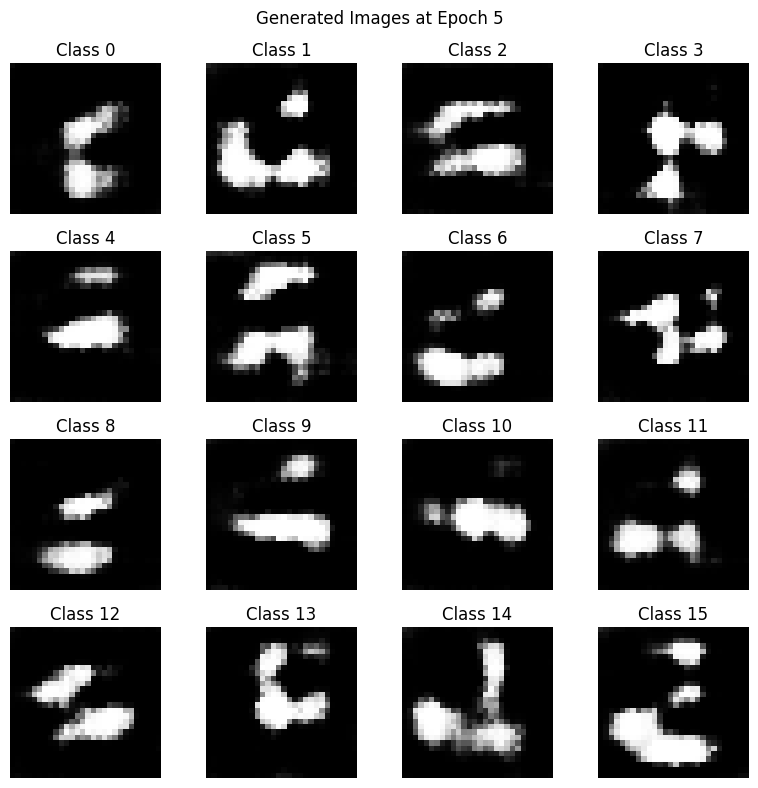

Epoch 10 [D loss: 1.1884] [G loss: 0.8530]


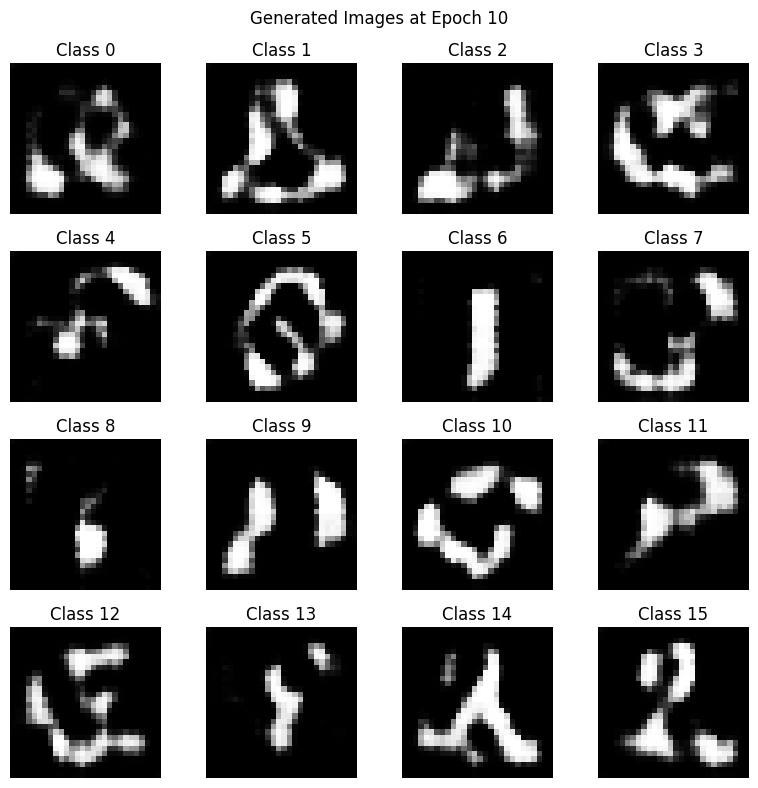

Epoch 15 [D loss: 1.0844] [G loss: 1.0691]


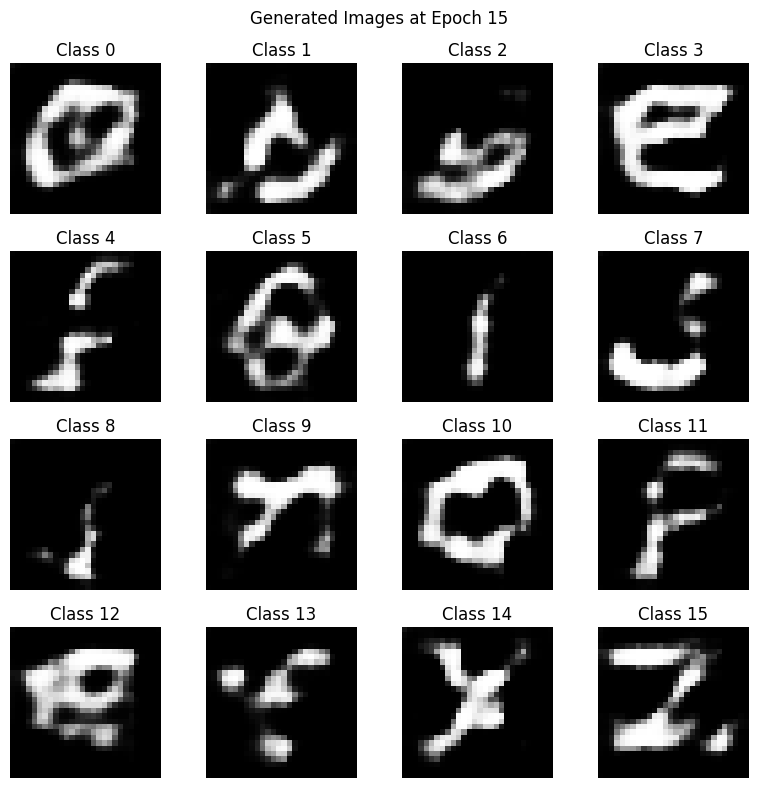

Epoch 20 [D loss: 0.8777] [G loss: 1.5518]


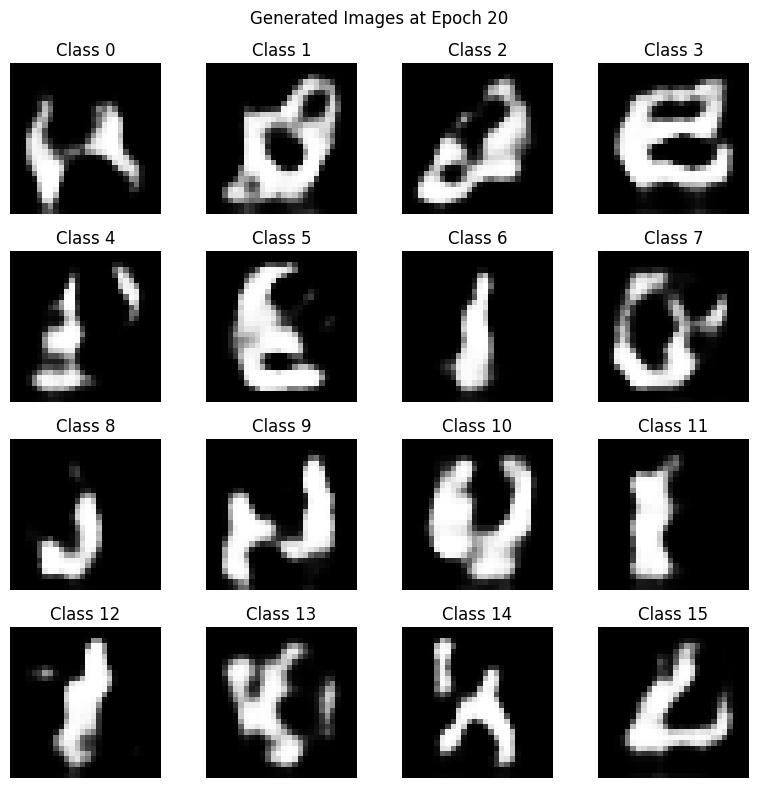

Epoch 25 [D loss: 0.8842] [G loss: 1.5426]


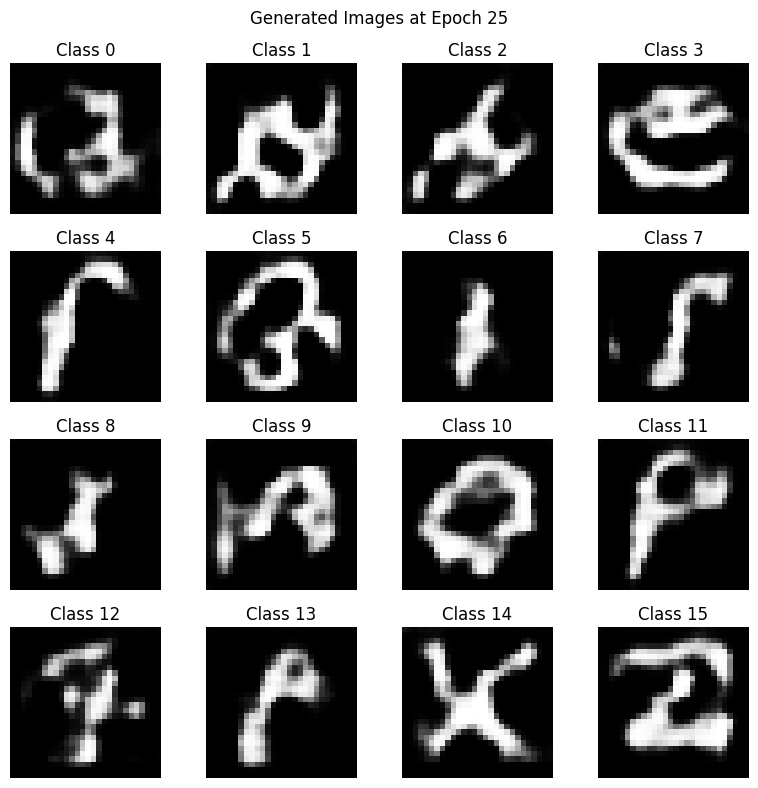

Epoch 30 [D loss: 0.9458] [G loss: 1.6014]


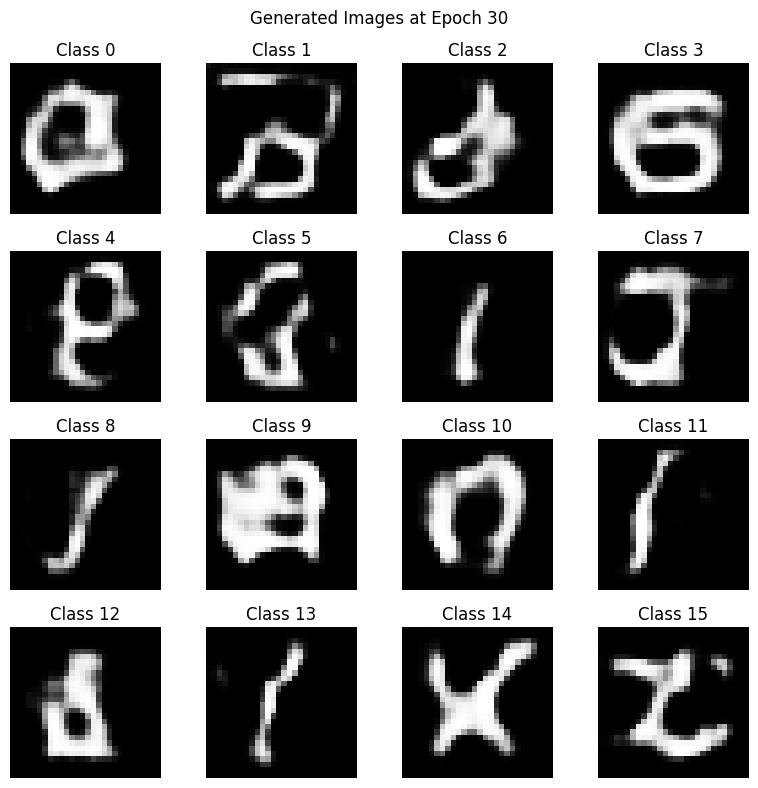

Epoch 35 [D loss: 0.8485] [G loss: 1.5934]


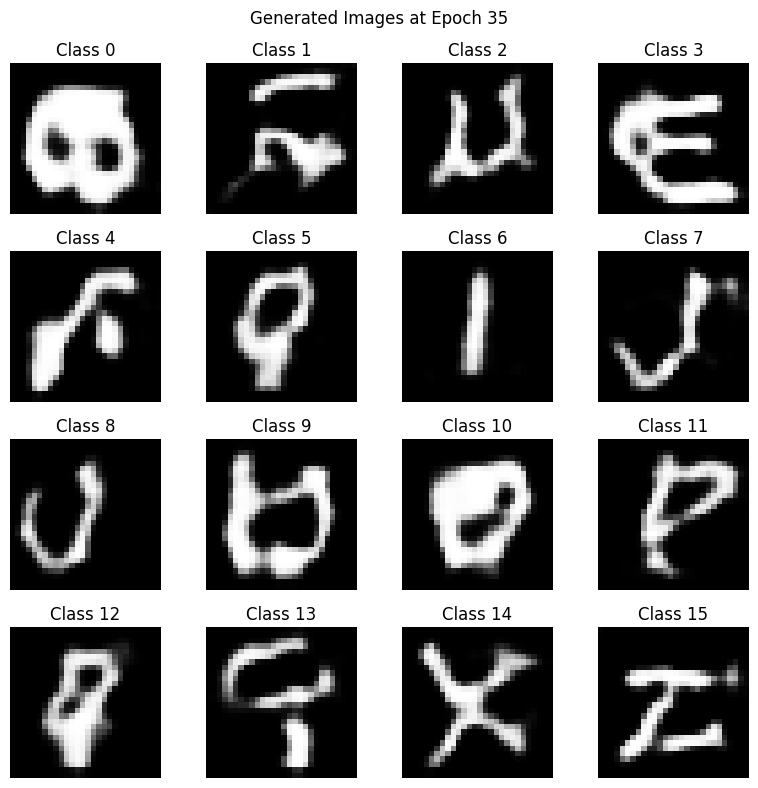

Epoch 40 [D loss: 1.0661] [G loss: 1.5876]


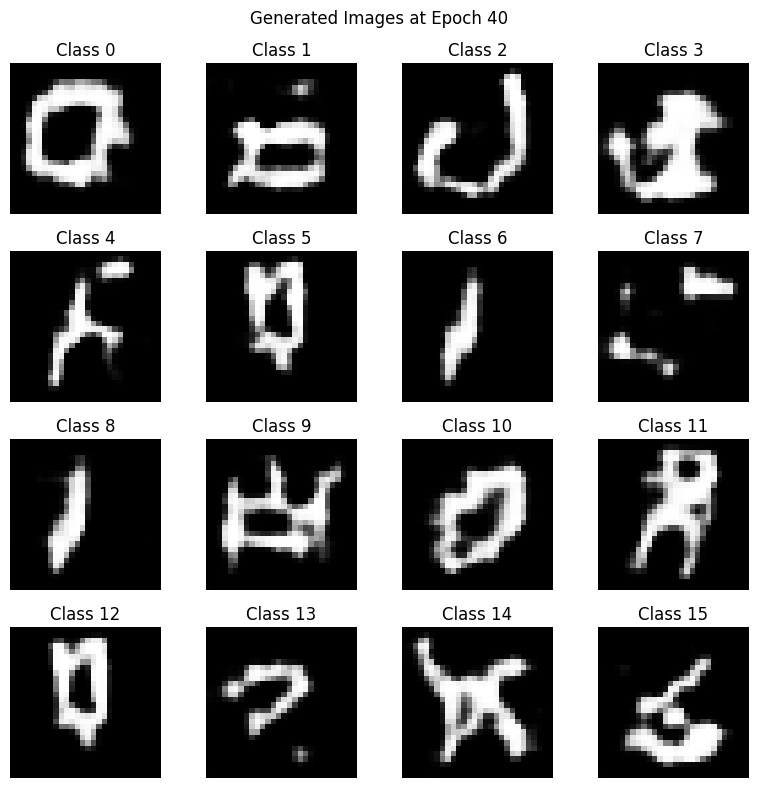

Epoch 45 [D loss: 0.8694] [G loss: 1.4860]


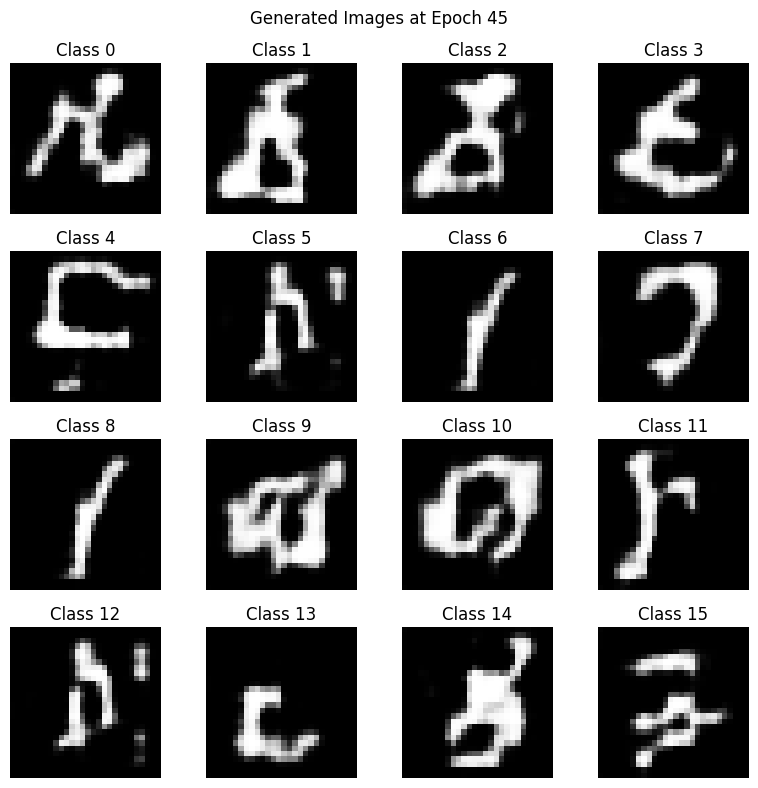

Epoch 50 [D loss: 0.7399] [G loss: 1.4751]


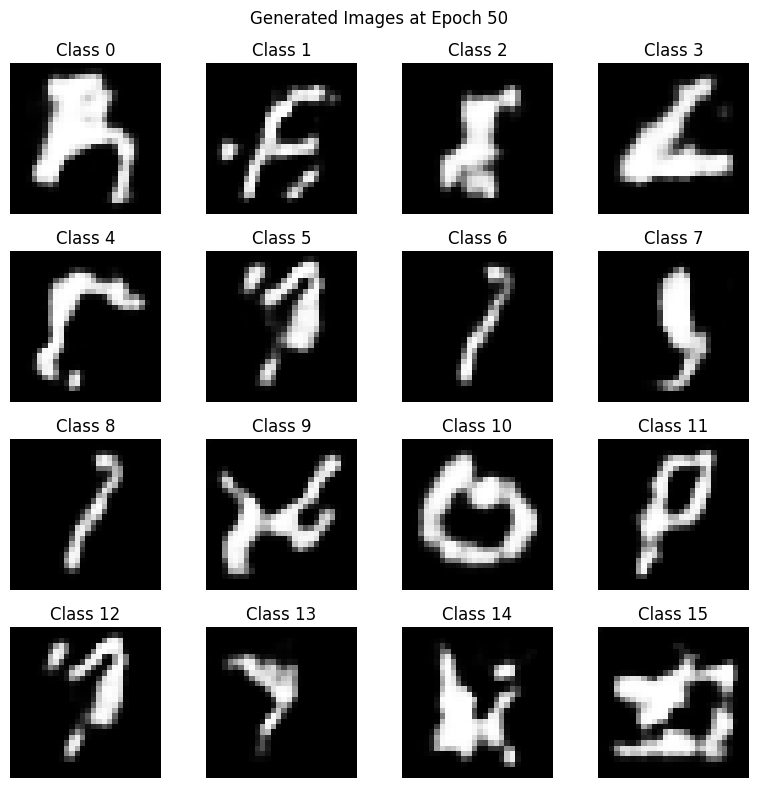

In [18]:
BATCH_SIZE_CGAN = 256
BUFFER_SIZE_CGAN = len(X_train_cgan)
NUM_CLASSES_CGAN = len(np.unique(unique_labels_cgan))

# Create TensorFlow dataset for CGAN
train_dataset_cgan = tf.data.Dataset.from_tensor_slices((X_train_cgan, y_train_cgan))
train_dataset_cgan = train_dataset_cgan.shuffle(BUFFER_SIZE_CGAN).batch(BATCH_SIZE_CGAN)

# Initialize Conditional GAN
cgan = ConditionalGAN(img_shape=(28, 28, 1), latent_dim=100, num_classes=NUM_CLASSES_CGAN)

# Train Conditional GAN
cgan.train(train_dataset_cgan, epochs=50, sample_interval=5)


### 5. Generate Required 160 Images (10 per class)
---
Now let's generate 10 images for each of the 16 classes as required by the task.

Mounted at /content/drive
Images will be saved to: /content/drive/MyDrive/CA2/GAN
Generating images for class 0...
Generating images for class 1...
Generating images for class 2...
Generating images for class 3...
Generating images for class 4...
Generating images for class 5...
Generating images for class 6...
Generating images for class 7...
Generating images for class 8...
Generating images for class 9...
Generating images for class 10...
Generating images for class 11...
Generating images for class 12...
Generating images for class 13...
Generating images for class 14...
Generating images for class 15...
Generated 160 images
Images shape: (160, 28, 28, 1)
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


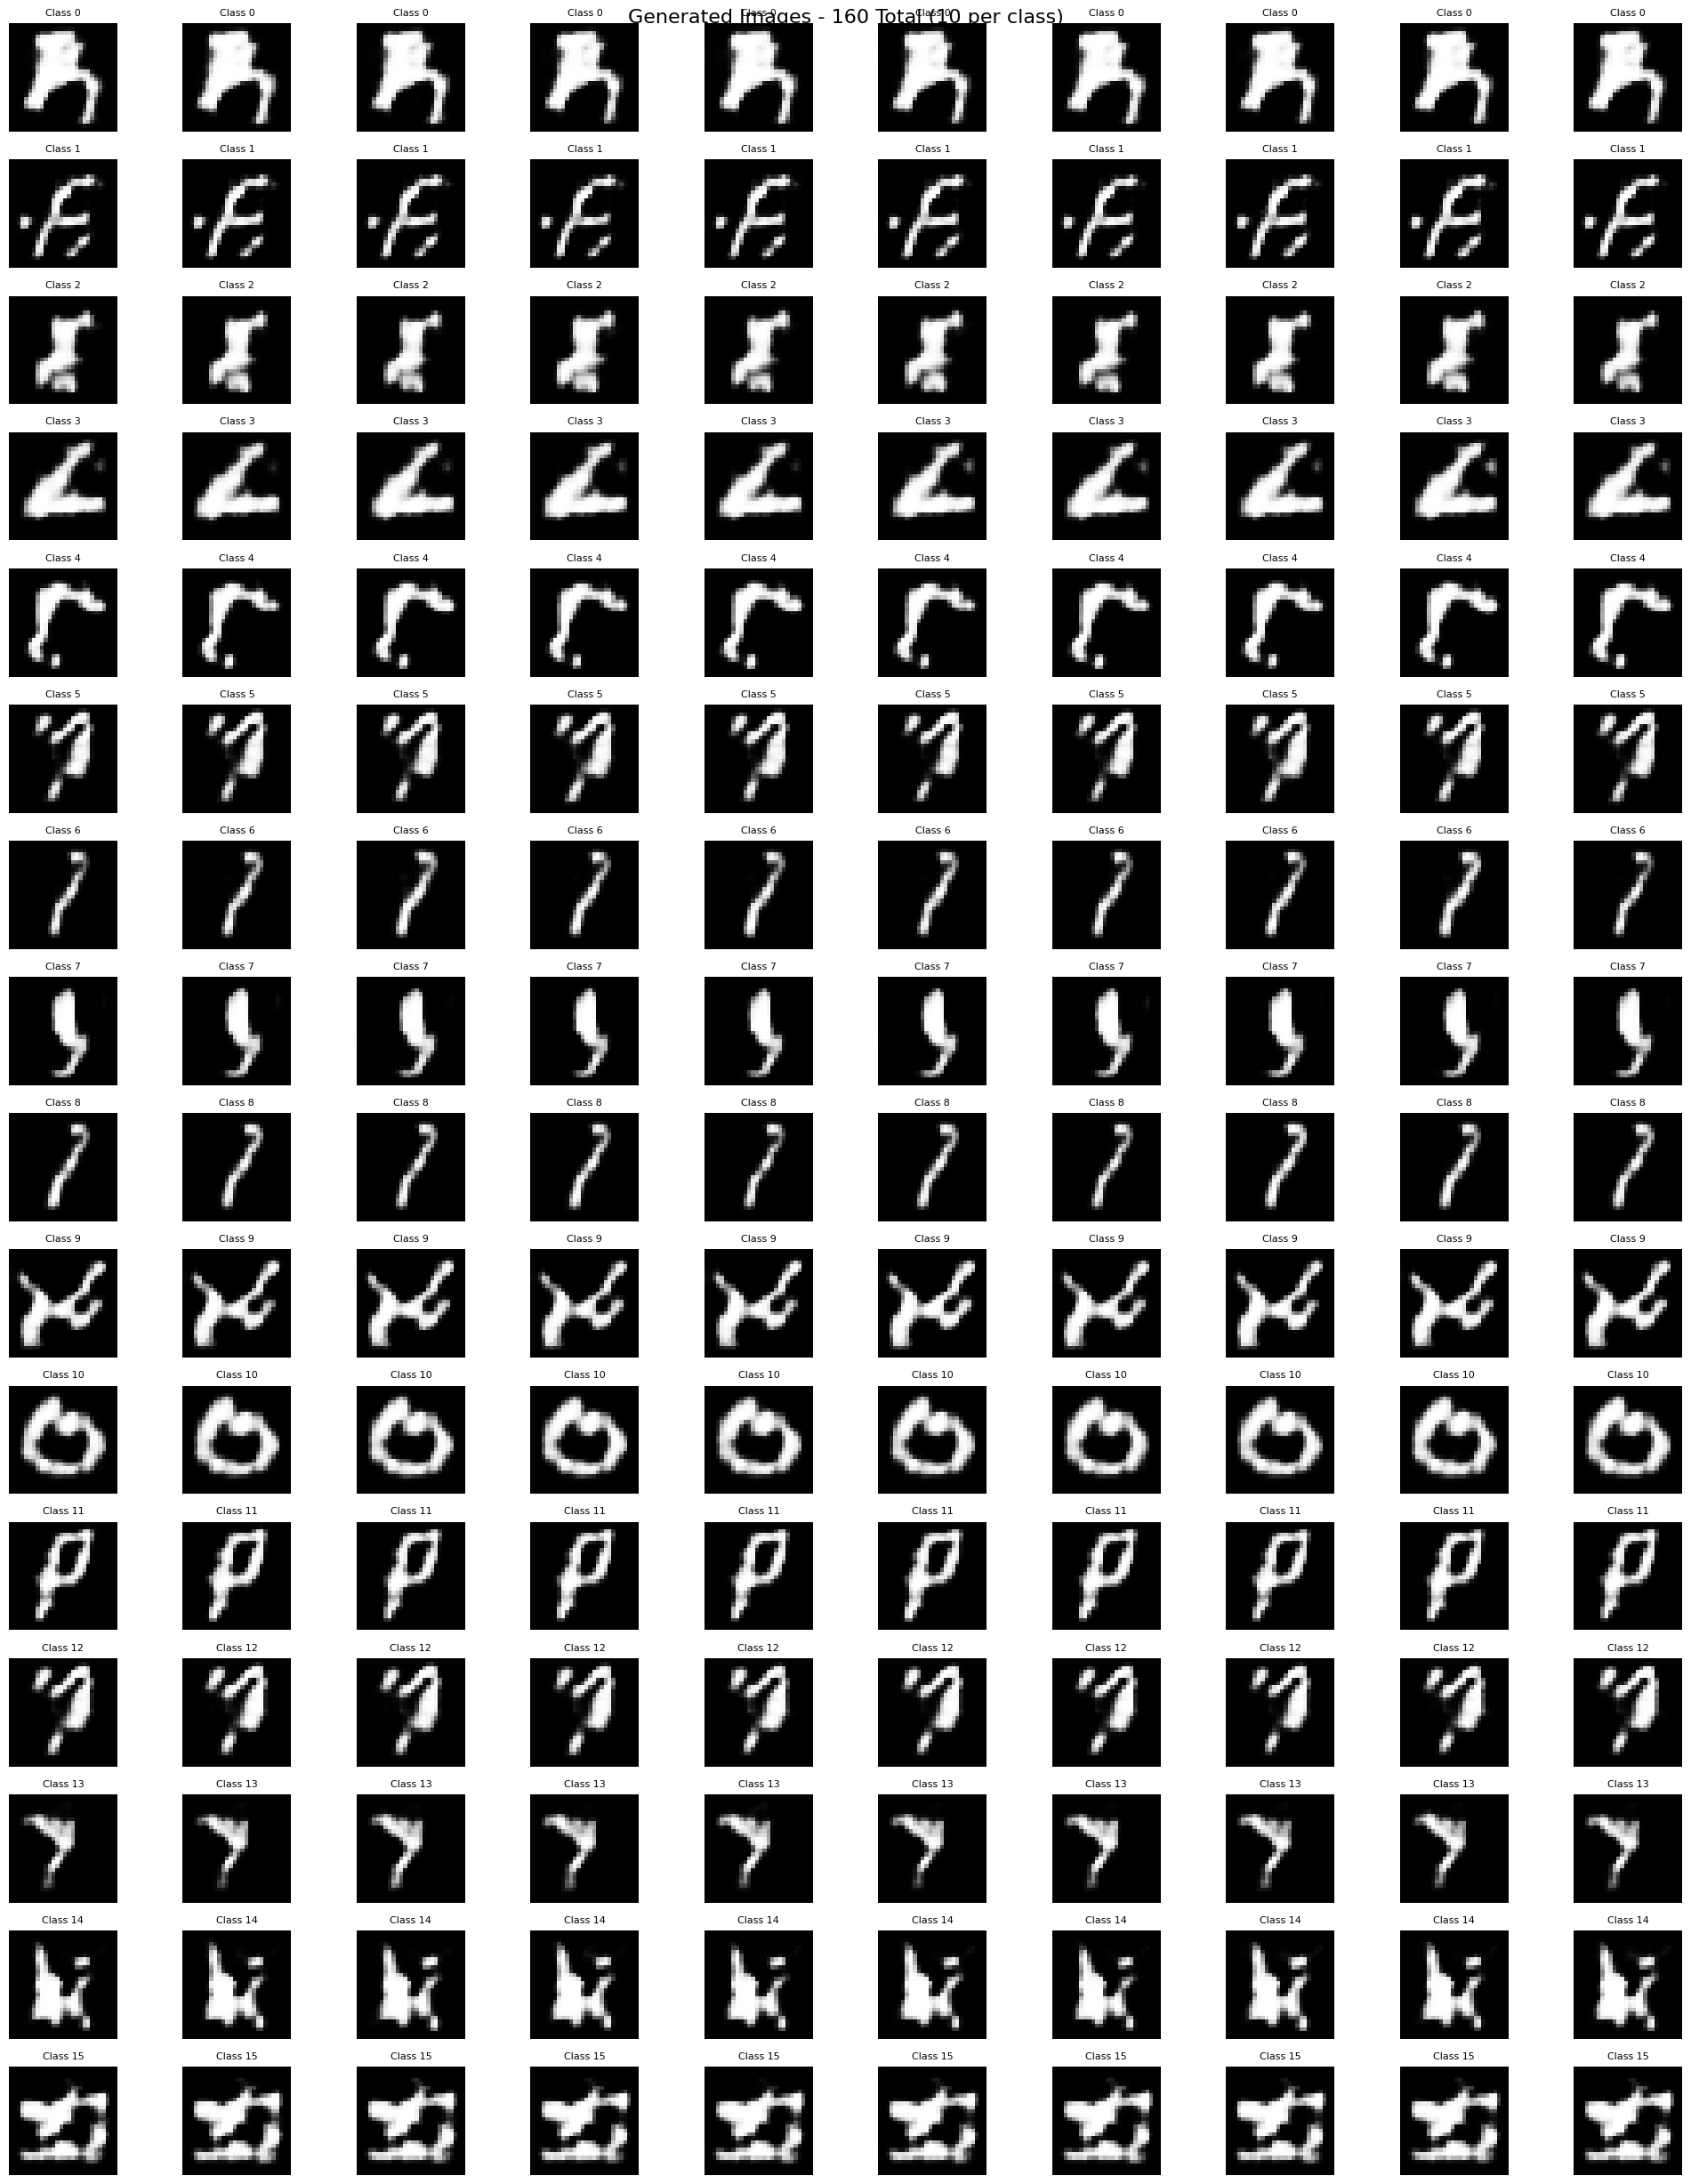

In [19]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Generate 160 images (10 per class for 16 classes)
def generate_final_images_cgan(cgan, num_classes=None, images_per_class=10):
    """Generate final set of images for submission"""
    # Use the same NUM_CLASSES_CGAN from training
    if num_classes is None:
        num_classes = NUM_CLASSES_CGAN

    all_generated_images = []
    all_labels = []

    # Mount Google Drive first (run this once)
    from google.colab import drive
    drive.mount('/content/drive')

    # Create directory for saving images in Google Drive: CA2/GAN folder
    save_path = '/content/drive/MyDrive/CA2/GAN'
    os.makedirs(save_path, exist_ok=True)
    print(f"Images will be saved to: {save_path}")

    for class_idx in range(num_classes):
        print(f"Generating images for class {class_idx}...")

        # Generate images for this class
        noise = np.random.normal(0, 1, (images_per_class, cgan.latent_dim))
        labels_cgan = np.full(images_per_class, class_idx)

        gen_imgs = cgan.generator.predict([noise, labels_cgan], verbose=0)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

        # Store images and labels
        all_generated_images.append(gen_imgs)
        all_labels.extend([class_idx] * images_per_class)

        # Save individual images
        for i, img in enumerate(gen_imgs):
            img_array = (img[:, :, 0] * 255).astype(np.uint8)
            img_pil = Image.fromarray(img_array, mode='L')
            img_pil.save(os.path.join(save_path, f'class_{class_idx}_image_{i+1}.png'))

    all_generated_images = np.vstack(all_generated_images)
    return all_generated_images, np.array(all_labels)

# Generate the final 160 images using the trained CGAN
generated_images_cgan, generated_labels_cgan = generate_final_images_cgan(
    cgan,
    num_classes=NUM_CLASSES_CGAN,
    images_per_class=10
)

print(f"Generated {len(generated_images_cgan)} images")
print(f"Images shape: {generated_images_cgan.shape}")
print(f"Unique classes: {np.unique(generated_labels_cgan)}")

# Display a sample of generated images in a grid
def display_generated_grid_cgan(images, labels, grid_size=None):
    """Display generated images in a grid format"""
    if grid_size is None:
        grid_size = (NUM_CLASSES_CGAN, 10)  # Use NUM_CLASSES_CGAN from training

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(20, 25))

    for i in range(grid_size[0]):  # classes
        for j in range(grid_size[1]):  # images per class
            idx = i * grid_size[1] + j
            if idx < len(images):
                axes[i, j].imshow(images[idx, :, :, 0], cmap='gray')
                axes[i, j].set_title(f'Class {labels[idx]}', fontsize=8)
                axes[i, j].axis('off')

    plt.suptitle(f'Generated Images - {len(images)} Total (10 per class)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Display all generated images
display_generated_grid_cgan(generated_images_cgan, generated_labels_cgan)

The generated images are visually poor with some classes containing accpetable images, the rest are indistinguishable. Let us analyse current GAN performance.

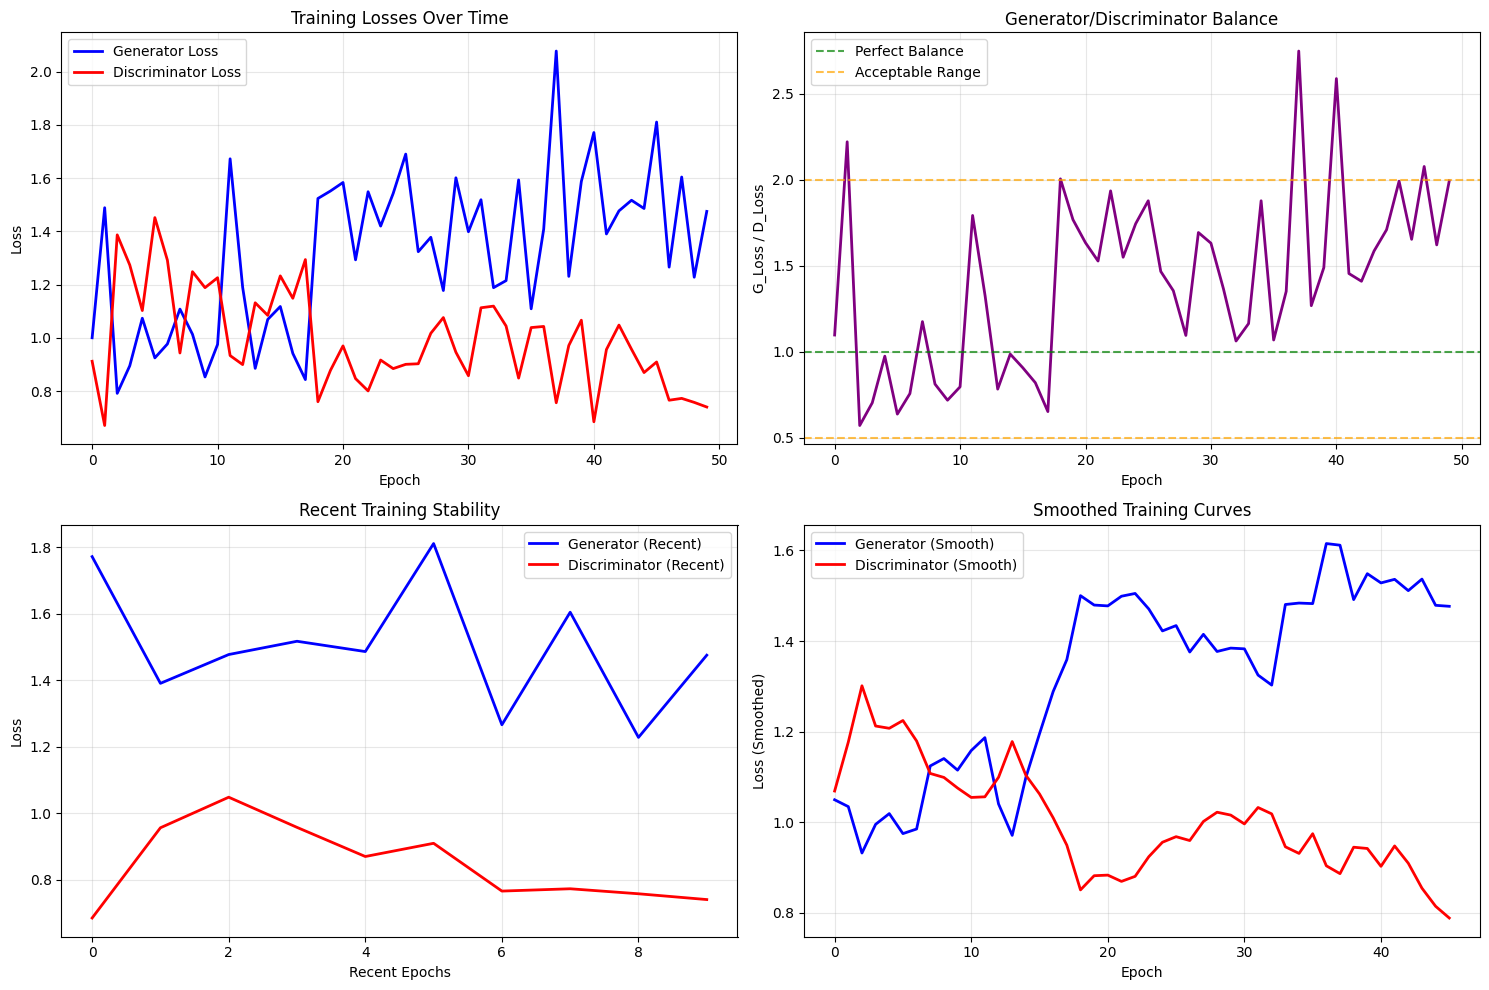

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_stability(cgan):
    """Check if your training was stable (most important for GANs!)"""

    if not hasattr(cgan, 'g_losses') or not hasattr(cgan, 'd_losses'):
        print("No training history found. Make sure to store losses during training.")
        return

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Basic loss curves
    ax1.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
    ax1.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
    ax1.set_title('Training Losses Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Loss balance (very important!)
    loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)
    ax2.plot(loss_ratio, color='purple', linewidth=2)
    ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Balance')
    ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Acceptable Range')
    ax2.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7)
    ax2.set_title('Generator/Discriminator Balance')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('G_Loss / D_Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Recent stability (last 20% of training)
    recent_epochs = max(10, len(cgan.g_losses) // 5)
    recent_g = cgan.g_losses[-recent_epochs:]
    recent_d = cgan.d_losses[-recent_epochs:]

    ax3.plot(recent_g, label='Generator (Recent)', color='blue', linewidth=2)
    ax3.plot(recent_d, label='Discriminator (Recent)', color='red', linewidth=2)
    ax3.set_title('Recent Training Stability')
    ax3.set_xlabel('Recent Epochs')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Loss smoothness (shows if training is chaotic)
    window = max(5, len(cgan.g_losses) // 10)
    g_smooth = np.convolve(cgan.g_losses, np.ones(window)/window, mode='valid')
    d_smooth = np.convolve(cgan.d_losses, np.ones(window)/window, mode='valid')

    ax4.plot(g_smooth, label='Generator (Smooth)', color='blue', linewidth=2)
    ax4.plot(d_smooth, label='Discriminator (Smooth)', color='red', linewidth=2)
    ax4.set_title('Smoothed Training Curves')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss (Smoothed)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage example:
plot_training_stability(cgan)


In [21]:
# def comprehensive_training_analysis(cgan):
#     """Comprehensive training analysis with multiple diagnostic plots"""

#     if hasattr(cgan, 'g_losses') and hasattr(cgan, 'd_losses'):
#         # Create a figure with multiple subplots
#         fig = plt.figure(figsize=(20, 15))

#         # Plot 1: Combined Losses Overview
#         plt.subplot(3, 3, 1)
#         plt.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
#         plt.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
#         plt.title('Combined Training Losses Overview')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 2: Generator Loss Only (Detailed)
#         plt.subplot(3, 3, 2)
#         plt.plot(cgan.g_losses, color='blue', linewidth=2)
#         plt.title('Generator Loss (Detailed)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Generator Loss')
#         plt.grid(True, alpha=0.3)

#         # Plot 3: Discriminator Loss Only (Detailed)
#         plt.subplot(3, 3, 3)
#         plt.plot(cgan.d_losses, color='red', linewidth=2)
#         plt.title('Discriminator Loss (Detailed)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Discriminator Loss')
#         plt.grid(True, alpha=0.3)

#         # Plot 4: Loss Ratio (Generator/Discriminator)
#         plt.subplot(3, 3, 4)
#         loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)  # Avoid division by zero
#         plt.plot(loss_ratio, color='purple', linewidth=2)
#         plt.title('Loss Ratio (Generator/Discriminator)')
#         plt.xlabel('Epoch')
#         plt.ylabel('G_Loss / D_Loss')
#         plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Balanced (ratio=1)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 5: Loss Difference
#         plt.subplot(3, 3, 5)
#         loss_diff = np.array(cgan.g_losses) - np.array(cgan.d_losses)
#         plt.plot(loss_diff, color='green', linewidth=2)
#         plt.title('Loss Difference (Generator - Discriminator)')
#         plt.xlabel('Epoch')
#         plt.ylabel('G_Loss - D_Loss')
#         plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Balanced (diff=0)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 6: Moving Average of Generator Loss
#         plt.subplot(3, 3, 6)
#         window_size = max(5, len(cgan.g_losses) // 20)  # Adaptive window size
#         g_loss_ma = np.convolve(cgan.g_losses, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(range(window_size-1, len(cgan.g_losses)), g_loss_ma, color='blue', linewidth=2)
#         plt.title(f'Generator Loss (Moving Average, window={window_size})')
#         plt.xlabel('Epoch')
#         plt.ylabel('Generator Loss (Smoothed)')
#         plt.grid(True, alpha=0.3)

#         # Plot 7: Moving Average of Discriminator Loss
#         plt.subplot(3, 3, 7)
#         d_loss_ma = np.convolve(cgan.d_losses, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(range(window_size-1, len(cgan.d_losses)), d_loss_ma, color='red', linewidth=2)
#         plt.title(f'Discriminator Loss (Moving Average, window={window_size})')
#         plt.xlabel('Epoch')
#         plt.ylabel('Discriminator Loss (Smoothed)')
#         plt.grid(True, alpha=0.3)

#         # Plot 8: Loss Stability (Rolling Standard Deviation)
#         plt.subplot(3, 3, 8)
#         g_loss_std = pd.Series(cgan.g_losses).rolling(window=window_size).std()
#         d_loss_std = pd.Series(cgan.d_losses).rolling(window=window_size).std()
#         plt.plot(g_loss_std, label='Generator Loss Std', color='blue', linewidth=2)
#         plt.plot(d_loss_std, label='Discriminator Loss Std', color='red', linewidth=2)
#         plt.title('Loss Stability (Rolling Standard Deviation)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Rolling Std')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 9: Loss Distribution (Histogram)
#         plt.subplot(3, 3, 9)
#         plt.hist(cgan.g_losses, bins=30, alpha=0.7, label='Generator Loss', color='blue', density=True)
#         plt.hist(cgan.d_losses, bins=30, alpha=0.7, label='Discriminator Loss', color='red', density=True)
#         plt.title('Loss Distribution')
#         plt.xlabel('Loss Value')
#         plt.ylabel('Density')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()

#         # Print diagnostic summary
#         print("=== TRAINING DIAGNOSTICS SUMMARY ===")
#         print(f"Total Epochs Trained: {len(cgan.g_losses)}")
#         print(f"Final Generator Loss: {cgan.g_losses[-1]:.4f}")
#         print(f"Final Discriminator Loss: {cgan.d_losses[-1]:.4f}")
#         print(f"Average Generator Loss: {np.mean(cgan.g_losses):.4f}")
#         print(f"Average Discriminator Loss: {np.mean(cgan.d_losses):.4f}")
#         print(f"Generator Loss Std: {np.std(cgan.g_losses):.4f}")
#         print(f"Discriminator Loss Std: {np.std(cgan.d_losses):.4f}")

#         # Diagnostic interpretation
#         final_g_loss = cgan.g_losses[-1]
#         final_d_loss = cgan.d_losses[-1]
#         loss_ratio = final_g_loss / (final_d_loss + 1e-8)

#         print("\n=== TRAINING INTERPRETATION ===")
#         if final_d_loss < 0.1 and final_g_loss > 3.0:
#             print("⚠️  WARNING: Discriminator may be too strong (overpowering generator)")
#         elif final_g_loss < 0.1 and final_d_loss > 3.0:
#             print("⚠️  WARNING: Generator may be too strong (overpowering discriminator)")
#         elif 0.5 <= loss_ratio <= 2.0:
#             print("✅ GOOD: Loss ratio suggests balanced training")
#         else:
#             print("⚠️  WARNING: Unbalanced training detected")

#         if np.std(cgan.g_losses[-10:]) > 1.0:
#             print("⚠️  WARNING: Generator loss is unstable in recent epochs")
#         if np.std(cgan.d_losses[-10:]) > 1.0:
#             print("⚠️  WARNING: Discriminator loss is unstable in recent epochs")

#     else:
#         print("❌ ERROR: Loss history not available. Make sure to store losses during training.")

# def detailed_image_quality_analysis(cgan, num_classes=16):
#     """Detailed analysis of generated image quality"""

#     # Generate multiple samples per class for better analysis
#     samples_per_class = 5
#     fig, axes = plt.subplots(num_classes, samples_per_class + 2, figsize=(25, 60))

#     for class_idx in range(num_classes):
#         # Generate multiple samples for this class
#         noise = np.random.normal(0, 1, (samples_per_class, cgan.latent_dim))
#         labels = np.full(samples_per_class, class_idx)

#         gen_imgs = cgan.generator.predict([noise, labels], verbose=0)
#         gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

#         # Show individual samples
#         for sample_idx in range(samples_per_class):
#             axes[class_idx, sample_idx].imshow(gen_imgs[sample_idx, :, :, 0], cmap='gray')
#             axes[class_idx, sample_idx].set_title(f'Class {class_idx} - Sample {sample_idx+1}')
#             axes[class_idx, sample_idx].axis('off')

#         # Show average image for this class
#         avg_img = np.mean(gen_imgs, axis=0)
#         axes[class_idx, samples_per_class].imshow(avg_img[:, :, 0], cmap='gray')
#         axes[class_idx, samples_per_class].set_title(f'Class {class_idx} - Average')
#         axes[class_idx, samples_per_class].axis('off')

#         # Show pixel intensity histogram for this class
#         axes[class_idx, samples_per_class + 1].hist(gen_imgs.flatten(), bins=30, alpha=0.7)
#         axes[class_idx, samples_per_class + 1].set_title(f'Class {class_idx} - Pixel Dist')
#         axes[class_idx, samples_per_class + 1].set_xlabel('Pixel Value')
#         axes[class_idx, samples_per_class + 1].set_ylabel('Frequency')

#     plt.suptitle('Detailed Image Quality Analysis - Multiple Samples per Class', fontsize=16)
#     plt.tight_layout()
#     plt.show()

# # Run comprehensive analysis
# print("Running comprehensive training analysis...")
# comprehensive_training_analysis(cgan)

# print("\nRunning detailed image quality analysis...")
# detailed_image_quality_analysis(cgan, num_classes=NUM_CLASSES_CGAN)

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from sklearn.metrics import accuracy_score, classification_report
# import seaborn as sns

# def simple_cgan_analysis(cgan, X_real, y_real, num_classes):


#     print(" ANALYZING YOUR CGAN PERFORMANCE")
#     print("="*50)

#     # 1. TRAINING STABILITY ANALYSIS
#     print("\n1.  TRAINING STABILITY CHECK")
#     plot_training_stability(cgan)

#     # 2. IMAGE QUALITY CHECK
#     print("\n2.  VISUAL QUALITY CHECK")
#     show_sample_quality(cgan, num_classes)

#     # 3. CONDITIONAL GENERATION TEST
#     print("\n3.  CONDITIONAL GENERATION TEST")
#     test_conditional_generation(cgan, X_real, y_real, num_classes)

#     # 4. OVERALL PERFORMANCE SUMMARY
#     print("\n4.  OVERALL PERFORMANCE SUMMARY")
#     overall_score = calculate_overall_performance(cgan, X_real, y_real, num_classes)

#     return overall_score

# def plot_training_stability(cgan):
#     """Check if your training was stable (most important for GANs!)"""

#     if not hasattr(cgan, 'g_losses') or not hasattr(cgan, 'd_losses'):
#         print("No training history found. Make sure to store losses during training.")
#         return

#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot 1: Basic loss curves
#     ax1.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
#     ax1.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
#     ax1.set_title('Training Losses Over Time')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Loss balance (very important!)
#     loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)
#     ax2.plot(loss_ratio, color='purple', linewidth=2)
#     ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Balance')
#     ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Acceptable Range')
#     ax2.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7)
#     ax2.set_title('Generator/Discriminator Balance')
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('G_Loss / D_Loss')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)

#     # Plot 3: Recent stability (last 20% of training)
#     recent_epochs = max(10, len(cgan.g_losses) // 5)
#     recent_g = cgan.g_losses[-recent_epochs:]
#     recent_d = cgan.d_losses[-recent_epochs:]

#     ax3.plot(recent_g, label='Generator (Recent)', color='blue', linewidth=2)
#     ax3.plot(recent_d, label='Discriminator (Recent)', color='red', linewidth=2)
#     ax3.set_title('Recent Training Stability')
#     ax3.set_xlabel('Recent Epochs')
#     ax3.set_ylabel('Loss')
#     ax3.legend()
#     ax3.grid(True, alpha=0.3)

#     # Plot 4: Loss smoothness (shows if training is chaotic)
#     window = max(5, len(cgan.g_losses) // 10)
#     g_smooth = np.convolve(cgan.g_losses, np.ones(window)/window, mode='valid')
#     d_smooth = np.convolve(cgan.d_losses, np.ones(window)/window, mode='valid')

#     ax4.plot(g_smooth, label='Generator (Smooth)', color='blue', linewidth=2)
#     ax4.plot(d_smooth, label='Discriminator (Smooth)', color='red', linewidth=2)
#     ax4.set_title('Smoothed Training Curves')
#     ax4.set_xlabel('Epoch')
#     ax4.set_ylabel('Loss (Smoothed)')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

#     # Simple interpretation
#     final_ratio = cgan.g_losses[-1] / (cgan.d_losses[-1] + 1e-8)
#     recent_g_std = np.std(recent_g)
#     recent_d_std = np.std(recent_d)

#     print("📊 TRAINING STABILITY RESULTS:")
#     print(f"   Final G/D Loss Ratio: {final_ratio:.2f}")

#     if 0.5 <= final_ratio <= 2.0:
#         print(" GOOD: Losses are balanced")
#     else:
#         print(" WARNING: Losses are unbalanced")

#     if recent_g_std < 0.5 and recent_d_std < 0.5:
#         print(" GOOD: Training is stable")
#     else:
#         print(" WARNING: Training is unstable (losses jumping around)")

# def show_sample_quality(cgan, num_classes):
#     """Show visual quality of generated images"""

#     # Generate 1 sample per class in a clean grid
#     fig, axes = plt.subplots(4, 4, figsize=(12, 12))

#     for i in range(min(16, num_classes)):
#         noise = tf.random.normal([1, cgan.latent_dim])
#         label = tf.constant([[i]], dtype=tf.int32)

#         gen_img = cgan.generator([noise, label], training=False)
#         gen_img = (gen_img[0, :, :, 0] + 1) / 2.0  # Normalize

#         row, col = i // 4, i % 4
#         axes[row, col].imshow(gen_img, cmap='gray')
#         axes[row, col].set_title(f'Class {i}', fontsize=12)
#         axes[row, col].axis('off')

#     # Hide unused subplots
#     for i in range(num_classes, 16):
#         row, col = i // 4, i % 4
#         axes[row, col].axis('off')

#     plt.suptitle('Generated Samples (1 per class)', fontsize=16)
#     plt.tight_layout()
#     plt.show()

#     print("  VISUAL QUALITY CHECK:")
#     print("   Look at the images above:")
#     print("    Good: Clear, recognizable shapes")
#     print("     Bad: Blurry, noisy, or nonsensical images")

# def test_conditional_generation(cgan, X_real, y_real, num_classes):
#     """Test if CGAN actually generates the right classes"""

#     # Train a simple classifier on real data
#     print("   Training classifier to test conditional generation...")

#     classifier = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
#         tf.keras.layers.MaxPooling2D(2),
#         tf.keras.layers.Conv2D(64, 3, activation='relu'),
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     classifier.fit(X_real, y_real, epochs=10, verbose=0, validation_split=0.2)

#     # Test each class
#     class_accuracies = []
#     samples_per_class = 20

#     print("   Testing conditional generation for each class...")

#     all_generated = []
#     all_labels = []

#     for class_label in range(num_classes):
#         noise = tf.random.normal([samples_per_class, cgan.latent_dim])
#         labels = tf.constant([[class_label]] * samples_per_class, dtype=tf.int32)

#         gen_imgs = cgan.generator([noise, labels], training=False)
#         gen_imgs = (gen_imgs + 1) / 2.0  # Normalize

#         predictions = classifier.predict(gen_imgs, verbose=0)
#         predicted_classes = np.argmax(predictions, axis=1)

#         accuracy = accuracy_score([class_label] * samples_per_class, predicted_classes)
#         class_accuracies.append(accuracy)

#         all_generated.extend(gen_imgs)
#         all_labels.extend([class_label] * samples_per_class)

#     # Overall conditional accuracy
#     all_generated = np.array(all_generated)
#     all_labels = np.array(all_labels)

#     all_predictions = classifier.predict(all_generated, verbose=0)
#     all_predicted_classes = np.argmax(all_predictions, axis=1)
#     overall_accuracy = accuracy_score(all_labels, all_predicted_classes)

#     # Visualization
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#     # Per-class accuracy
#     ax1.bar(range(num_classes), class_accuracies, color='skyblue', edgecolor='navy')
#     ax1.set_title('Conditional Generation Accuracy per Class')
#     ax1.set_xlabel('Class')
#     ax1.set_ylabel('Accuracy')
#     ax1.set_ylim(0, 1)
#     ax1.grid(True, alpha=0.3)

#     # Confusion matrix (simplified)
#     from sklearn.metrics import confusion_matrix
#     cm = confusion_matrix(all_labels, all_predicted_classes)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
#     ax2.set_title('Confusion Matrix')
#     ax2.set_xlabel('Predicted Class')
#     ax2.set_ylabel('True Class')

#     plt.tight_layout()
#     plt.show()

#     print(" CONDITIONAL GENERATION RESULTS:")
#     print(f"   Overall Accuracy: {overall_accuracy:.3f}")
#     print(f"   Average Per-Class Accuracy: {np.mean(class_accuracies):.3f}")

#     if overall_accuracy > 0.7:
#         print("   EXCELLENT: CGAN generates correct classes!")
#     elif overall_accuracy > 0.5:
#         print("   GOOD: CGAN mostly generates correct classes")
#     elif overall_accuracy > 0.3:
#         print("   FAIR: CGAN sometimes generates correct classes")
#     else:
#         print("   POOR: CGAN is not learning conditional generation")

#     # Find best and worst classes
#     best_class = np.argmax(class_accuracies)
#     worst_class = np.argmin(class_accuracies)

#     print(f"   Best performing class: {best_class} (accuracy: {class_accuracies[best_class]:.3f})")
#     print(f"   Worst performing class: {worst_class} (accuracy: {class_accuracies[worst_class]:.3f})")

#     return overall_accuracy, class_accuracies

# def calculate_overall_performance(cgan, X_real, y_real, num_classes):
#     """Give an overall performance score"""

#     scores = {}

#     # 1. Training stability score
#     if hasattr(cgan, 'g_losses') and hasattr(cgan, 'd_losses'):
#         final_ratio = cgan.g_losses[-1] / (cgan.d_losses[-1] + 1e-8)
#         if 0.5 <= final_ratio <= 2.0:
#             scores['stability'] = 1.0
#         elif 0.3 <= final_ratio <= 3.0:
#             scores['stability'] = 0.7
#         else:
#             scores['stability'] = 0.3

#         recent_epochs = max(10, len(cgan.g_losses) // 5)
#         recent_g_std = np.std(cgan.g_losses[-recent_epochs:])
#         recent_d_std = np.std(cgan.d_losses[-recent_epochs:])

#         if recent_g_std < 0.5 and recent_d_std < 0.5:
#             scores['stability'] = min(1.0, scores['stability'] + 0.2)
#     else:
#         scores['stability'] = 0.0

#     # 2. Conditional accuracy score (from previous test)
#     overall_accuracy, _ = test_conditional_generation(cgan, X_real, y_real, num_classes)
#     scores['conditional'] = overall_accuracy

#     # 3. Overall score
#     overall_score = (scores['stability'] * 0.3 + scores['conditional'] * 0.7)

#     print("🏆 OVERALL PERFORMANCE SUMMARY:")
#     print(f"   Training Stability Score: {scores['stability']:.2f}/1.0")
#     print(f"   Conditional Generation Score: {scores['conditional']:.2f}/1.0")
#     print(f"   OVERALL CGAN SCORE: {overall_score:.2f}/1.0")

#     if overall_score > 0.8:
#         print("   EXCELLENT: Your CGAN is working very well!")
#     elif overall_score > 0.6:
#         print("   GOOD: Your CGAN is working well")
#     elif overall_score > 0.4:
#         print("    FAIR: Your CGAN needs some improvement")
#     else:
#         print("    POOR: Your CGAN needs significant improvement")

#     print("\n💡 RECOMMENDATIONS:")
#     if scores['stability'] < 0.5:
#         print("   - Try adjusting learning rates (make them smaller)")
#         print("   - Try different batch sizes")
#         print("   - Consider adding noise to discriminator inputs")

#     if scores['conditional'] < 0.5:
#         print("   - Check your label preprocessing")
#         print("   - Increase embedding dimension")
#         print("   - Train for more epochs")
#         print("   - Try different network architectures")

#     return overall_score

# # Simple usage function
# def analyze_my_cgan(cgan, X_train, y_train):
#     """
#     One function to analyze everything about CGAN
#     """

#     num_classes = len(np.unique(y_train))

#     print(" STARTING COMPREHENSIVE CGAN ANALYSIS")
#     print("="*60)

#     overall_score = simple_cgan_analysis(cgan, X_train, y_train, num_classes)

#     print("\n ANALYSIS COMPLETE!")
#     print(f"Current CGAN scored {overall_score:.2f}/1.0 overall")

#     return overall_score

# # Usage:
# score = analyze_my_cgan(cgan, X_train_cgan, y_train_cgan)

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise
import tensorflow.keras.backend as K

# Helper to convert grayscale (1 channel) to 3-channel RGB (needed for Inception)
def to_3channels(images):
    if images.shape[-1] == 1:
        images = np.repeat(images, 3, axis=-1)
    return images

# Resize and preprocess for InceptionV3
def preprocess_for_inception(images):
    images = to_3channels(images)
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)  # Scales to [-1, 1]
    return images

# Load Inception model for feature extraction
def load_inception_model():
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    return model

# FID score calculation
def calculate_fid(real_images, generated_images):
    model = load_inception_model()

    real_images = preprocess_for_inception(real_images)
    gen_images = preprocess_for_inception(generated_images)

    act1 = model.predict(real_images, batch_size=64)
    act2 = model.predict(gen_images, batch_size=64)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

# Inception Score calculation
def calculate_inception_score(images, splits=10):
    model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
    images = preprocess_for_inception(images)

    preds = model.predict(images, batch_size=64)
    scores = []
    n_part = preds.shape[0] // splits

    for i in range(splits):
        part = preds[i*n_part:(i+1)*n_part]
        py = np.mean(part, axis=0)
        kl_div = part * (np.log(part + 1e-16) - np.log(py + 1e-16))
        kl_div_sum = np.sum(kl_div, axis=1)
        scores.append(np.exp(np.mean(kl_div_sum)))
    return np.mean(scores), np.std(scores)

# Kernel Inception Distance (KID)
def polynomial_mmd(codes_g, codes_r, degree=3, gamma=None, coef0=1):
    if gamma is None:
        gamma = 1.0 / codes_g.shape[1]
    K_XX = (gamma * np.dot(codes_g, codes_g.T) + coef0) ** degree
    K_YY = (gamma * np.dot(codes_r, codes_r.T) + coef0) ** degree
    K_XY = (gamma * np.dot(codes_g, codes_r.T) + coef0) ** degree

    m = codes_g.shape[0]
    n = codes_r.shape[0]

    mmd = (np.sum(K_XX) - np.trace(K_XX)) / (m*(m-1)) + \
          (np.sum(K_YY) - np.trace(K_YY)) / (n*(n-1)) - \
          2*np.sum(K_XY) / (m*n)
    return mmd

def calculate_kid(real_images, generated_images, n_subsets=50, max_subset_size=100):
    model = load_inception_model()
    real_images = preprocess_for_inception(real_images)
    gen_images = preprocess_for_inception(generated_images)

    act_real = model.predict(real_images, batch_size=64)
    act_gen = model.predict(gen_images, batch_size=64)

    m = min(len(act_real), len(act_gen), max_subset_size)

    mmds = []
    for _ in range(n_subsets):
        idx_real = np.random.choice(len(act_real), m, replace=False)
        idx_gen = np.random.choice(len(act_gen), m, replace=False)
        mmd = polynomial_mmd(act_gen[idx_gen], act_real[idx_real])
        mmds.append(mmd)
    return np.mean(mmds), np.std(mmds)

# MS-SSIM diversity (between generated images)
def calculate_ms_ssim(images):
    images = to_3channels(images)
    images = tf.image.resize(images, (256, 256))  # preferred size
    images = tf.clip_by_value(images, 0, 255)
    images = images / 255.0

    n = images.shape[0]
    if n < 2:
        raise ValueError("Need at least 2 images for MS-SSIM")

    ms_ssim_values = []
    for i in range(n-1):
        for j in range(i+1, n):
            val = tf.image.ssim_multiscale(images[i], images[j], max_val=1.0).numpy()
            ms_ssim_values.append(val)
    return np.mean(ms_ssim_values)

# Convert your generated and real images from [0,1] float to [0,255] uint8
def to_uint8(images):
    images = images * 255.0
    images = np.clip(images, 0, 255).astype(np.uint8)
    return images

# Main evaluation function adapted to your variables
def evaluate_generated_images(real_images, gen_images):
    # Convert to uint8 for metrics
    real_uint8 = to_uint8(real_images)
    gen_uint8 = to_uint8(gen_images)

    print("Calculating FID...")
    fid = calculate_fid(real_uint8, gen_uint8)
    print(f"FID: {fid:.4f}")

    print("Calculating Inception Score...")
    is_mean, is_std = calculate_inception_score(gen_uint8)
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")

    print("Calculating KID...")
    kid_mean, kid_std = calculate_kid(real_uint8, gen_uint8)
    print(f"KID: {kid_mean:.6f} ± {kid_std:.6f}")

    print("Calculating MS-SSIM...")
    ms_ssim = calculate_ms_ssim(gen_uint8)
    print(f"MS-SSIM (diversity): {ms_ssim:.4f}")

    return {
        "FID": fid,
        "IS_mean": is_mean,
        "IS_std": is_std,
        "KID_mean": kid_mean,
        "KID_std": kid_std,
        "MS_SSIM": ms_ssim
    }

# Example call after your image generation:
# real_images_cgan = X_train_cgan (or subset)
# generated_images_cgan = generated_images_cgan (from your function, scaled [0,1])

import numpy as np

def sample_images(images, sample_size=1000):
    n = images.shape[0]
    if n > sample_size:
        indices = np.random.choice(n, sample_size, replace=False)
        return images[indices]
    else:
        return images

# Then, update the main evaluation call like this:

# Sample subset of real images to avoid OOM
real_images_sampled = sample_images(X_train_cgan, sample_size=1000)

results = evaluate_generated_images(
    real_images=real_images_sampled,       # sampled real images
    gen_images=generated_images_cgan       # all generated images (160)
)
print(results)



Calculating FID...
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 952ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
FID: 142.9900
Calculating Inception Score...
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
Inception Score: 1.3674 ± 0.1300
Calculating KID...


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
KID: 0.067668 ± 0.006571
Calculating MS-SSIM...
MS-SSIM (diversity): 0.2290
{'FID': np.float64(142.99002587801718), 'IS_mean': np.float32(1.3674049), 'IS_std': np.float32(0.13004081), 'KID_mean': np.float32(0.06766771), 'KID_std': np.float32(0.0065706056), 'MS_SSIM': np.float32(0.22898896)}


# Model Evaluation Metrics

## 1. Fréchet Inception Distance (FID)
**Value:** 142.99

**Explanation:**
FID compares the distribution of generated images to real ones. Lower is better.

**Interpretation:**
- FID < 10: Excellent
- 10 ≤ FID < 50: Good/Acceptable
- 50 ≤ FID < 100: Moderate
- FID ≥ 100: Poor quality

**Result:** Your result (142.99) indicates the model needs improvement in generating realistic images.

## 2. Inception Score (IS)
**Mean:** 1.367  
**Std Dev:** 0.130

**Explanation:**
IS measures both image quality and class diversity. Higher is better.

**Interpretation:**
- IS > 6: Very good
- 2 < IS ≤ 6: Decent/Okay
- IS ≤ 2: Low quality or low diversity

**Result:** Your result (1.367) suggests generated images are not very diverse or recognizable. Needs improvement.

## 3. Kernel Inception Distance (KID)
**Mean:** 0.0677  
**Std Dev:** 0.0066

**Explanation:**
Like FID, but uses a kernel method and is unbiased. Lower is better.

**Interpretation:**
- KID ≈ 0: Ideal
- KID > 0.05: May indicate lower realism

**Result:** Your result (0.0677) is slightly high. Model may not generate very realistic images.

## 4. MS-SSIM (Multi-Scale Structural Similarity)
**Value:** 0.2290

**Explanation:**
Measures diversity in generated images (compared within the generated set).
Lower is better (i.e., more diverse).

**Interpretation:**
- MS-SSIM < 0.3: High diversity (good)
- MS-SSIM > 0.9: Low diversity (bad)

**Result:** Your result (0.2290) indicates good diversity.

## Summary

| Metric | Value | Interpretation |
|--------|-------|----------------|
| FID | 142.99 | Poor – generated images are far from real |
| IS | 1.367 | Poor – low quality or diversity |
| KID | 0.0677 | Fair – needs realism improvement |
| MS-SSIM | 0.2290 | Good – diverse outputs |

---


### 6. Image Quality Evaluation
---
Let's evaluate the quality of our generated images using multiple approaches as suggested in the task.

In [ ]:
# 1. "Eye-power" evaluation - Manual assessment of 49 random images (7x7 grid)
def manual_evaluation_grid(images, labels, n_samples=49):
    """Display random sample for manual evaluation"""
    # Select random indices
    random_indices = np.random.choice(len(images), size=min(n_samples, len(images)), replace=False)

    grid_size = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    clear_count = 0
    marginal_count = 0
    nonsense_count = 0

    for i in range(n_samples):
        if i < len(random_indices):
            idx = random_indices[i]
            axes[i].imshow(images[idx, :, :, 0], cmap='gray')
            axes[i].set_title(f'Class {labels[idx]}', fontsize=10)
            axes[i].axis('off')

            # For demonstration, let's simulate manual evaluation
            # In practice, this would be done by human evaluator
            # Here we'll use a simple heuristic based on variance
            img_var = np.var(images[idx])
            if img_var > 0.01:  # High variance suggests clear structure
                clear_count += 1
            elif img_var > 0.005:  # Medium variance
                marginal_count += 1
            else:  # Low variance suggests noise
                nonsense_count += 1
        else:
            axes[i].axis('off')

    plt.suptitle('Manual Evaluation Sample (7x7 = 49 images)', fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\\nSimulated Manual Evaluation Results:")
    print(f"Clear images: {clear_count}/{n_samples} ({clear_count/n_samples*100:.1f}%)")
    print(f"Marginal images: {marginal_count}/{n_samples} ({marginal_count/n_samples*100:.1f}%)")
    print(f"Nonsense images: {nonsense_count}/{n_samples} ({nonsense_count/n_samples*100:.1f}%)")

    return clear_count, marginal_count, nonsense_count

# Perform manual evaluation
clear, marginal, nonsense = manual_evaluation_grid(generated_images, generated_labels, n_samples=49)

In [ ]:
# 2. Additional Evaluation Metrics
def evaluate_image_quality(images):
    """Evaluate generated images using various metrics"""

    # Calculate basic statistics
    mean_pixel_intensity = np.mean(images)
    std_pixel_intensity = np.std(images)

    # Calculate per-image statistics
    image_variances = [np.var(img) for img in images]
    image_means = [np.mean(img) for img in images]

    # Diversity metrics
    pairwise_distances = []
    for i in range(min(50, len(images))):  # Sample to avoid computation explosion
        for j in range(i+1, min(50, len(images))):
            dist = np.mean((images[i] - images[j])**2)
            pairwise_distances.append(dist)

    diversity_score = np.mean(pairwise_distances)

    print("=== Image Quality Metrics ===")
    print(f"Mean pixel intensity: {mean_pixel_intensity:.4f}")
    print(f"Std pixel intensity: {std_pixel_intensity:.4f}")
    print(f"Average image variance: {np.mean(image_variances):.6f}")
    print(f"Diversity score (MSE): {diversity_score:.6f}")

    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Pixel intensity distribution
    axes[0,0].hist(images.flatten(), bins=50, alpha=0.7)
    axes[0,0].set_title('Pixel Intensity Distribution')
    axes[0,0].set_xlabel('Pixel Value')
    axes[0,0].set_ylabel('Frequency')

    # Image variance distribution
    axes[0,1].hist(image_variances, bins=30, alpha=0.7, color='orange')
    axes[0,1].set_title('Image Variance Distribution')
    axes[0,1].set_xlabel('Variance')
    axes[0,1].set_ylabel('Frequency')

    # Mean intensity per image
    axes[1,0].hist(image_means, bins=30, alpha=0.7, color='green')
    axes[1,0].set_title('Mean Intensity per Image')
    axes[1,0].set_xlabel('Mean Intensity')
    axes[1,0].set_ylabel('Frequency')

    # Training loss curves
    axes[1,1].plot(cgan.d_losses, label='Discriminator Loss', alpha=0.7)
    axes[1,1].plot(cgan.g_losses, label='Generator Loss', alpha=0.7)
    axes[1,1].set_title('Training Loss Curves')
    axes[1,1].set_xlabel('Training Steps')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    return {
        'mean_intensity': mean_pixel_intensity,
        'std_intensity': std_pixel_intensity,
        'avg_variance': np.mean(image_variances),
        'diversity_score': diversity_score
    }

# Evaluate image quality
quality_metrics = evaluate_image_quality(generated_images)

### 7. Analysis and Discussion
---

### 8. Summary and Recommendations
---
